# Real space analysis

Pass from reciprocal space and $S(Q)$ to real space and $G(r)$. Then analysis of peaks positions and coordination number. Follow the definitions of Petrillo and Sacchetti papers cited below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from pathlib import Path

import os
 
# change the current directory
# to specified directory
os.chdir(r"/home/simo/Scrivania/Thesis/7C2_Analysis/Real_space")

Define functions

In [2]:
def get_indices_in_range(lst, start, end):
    """
    Returns a new list containing only the indices of the values within the given range (inclusive).
    """
    return [i for i, x in enumerate(lst) if start <= x <= end]

def remove_indexes(my_list, indexes_to_remove):
    return [x for i, x in enumerate(my_list) if i not in indexes_to_remove]

def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)
    return col


def gaussian(x, a, x0, sigma):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2))

def gaussian_baseline(x, a, x0, sigma,b):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2)) + b

def gaussian_zero(x, a, sigma,b):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-x**2/ (2 * sigma**2)) + b


def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y


def my_round(x,dx):      # per avere dato + errore con le giuste cire significative (incertezza con una sola cifra significativa)  ---> da sistemare,quando dx salta di cifra x resta arrotondato a cifra sotto
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            if dx[i] < 1:
                dist = -int(np.log10(dx[i])-1)
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx[i]))
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)))
            round_x.append([x_new,dx_new])
    else:
            if dx < 1:
                dist = -int(np.log10(dx)-1)
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx))
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)))
            round_x.append([x_new, dx_new])
    return round_x

In [3]:


def my_round(x, dx):
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            dx_new, x_new = round_single_value(x[i], dx[i])
            round_x.append([x_new, dx_new])
    else:
        dx_new, x_new = round_single_value(x, dx)
        round_x.append([x_new, dx_new])
    return round_x

def round_single_value(x, dx):
    if dx == 0:
        return 0, x  # If dx is zero, return as is
    
    # Determine the number of decimal places to round to for dx to have 1 significant figure
    dist = -int(np.floor(np.log10(abs(dx)))) + 1
    
    # Round dx to 1 significant figure
    dx_new = round(dx, dist - 1)
    
    # Round x to the same decimal place as dx_new
    x_new = round(x, dist - 1)
    
    return dx_new, x_new

# Example usage
x = [123.456789, 78.9, 0.01234]
dx = [0.056, 0.9, 0.016]
rounded_values = my_round(x, dx)
print(rounded_values)

[[123.46, 0.06], [78.9, 0.9], [0.01, 0.02]]


# Import data

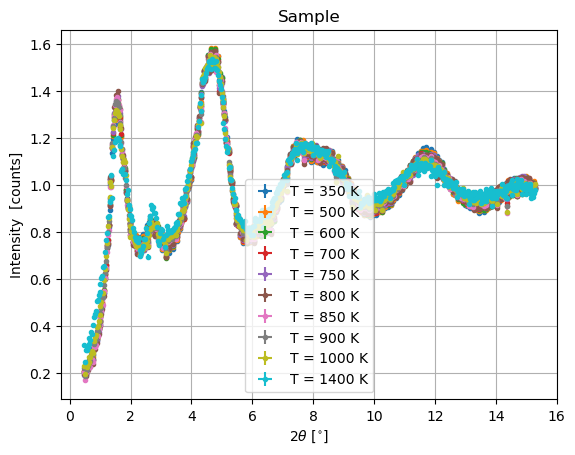

In [4]:
T = [350, 500, 600, 700, 750, 800, 850, 900, 1000,1400]

q = read_dat_file('q',1)[0]
err_q = read_dat_file('q',1)[1]

sdq = []
err_sdq = []

for i in range(len(T)):
    name = 'sdq' + str(T[i]) + 'K'
    data = read_dat_file(name,1)[1]
    err_data = read_dat_file(name,1)[2]

    sdq.append(data)
    err_sdq.append(err_data)

    plt.errorbar(q,data, fmt = '.', yerr = err_data , xerr=err_q,label = 'T = %d K' %T[i])
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Sample')
plt.grid()
plt.legend()
plt.show()

sdq = np.array(sdq)
err_sdq = np.array(err_sdq)

Retrieve densities and cross sections of GeO2.  
Molecular cross section are computed as the sum of the atomic ones.

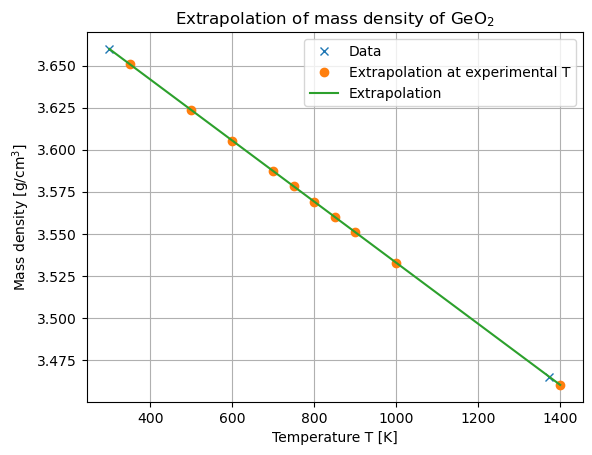

In [5]:
def lin_fit(x,a,b):
    return a*x+b

N = 6.022e23   #avogadro number


#GeO2

T_data = [300, 1373] #K
density = [3.66, 3.465]  # g/cm^3

slope = (density[0]-density[1])/(T_data[0]-T_data[1])
intercept = (T_data[1]*density[0]-T_data[0]*density[1])/(T_data[1]-T_data[0])


density_geo2 = lin_fit(np.array(T),*[slope,intercept])

aw_ge = 72.63 #g/mol
aw_o = 15.9994 #g/mol
aw_geo2 = aw_ge + 2*aw_o #g/mol

w_ge = aw_ge/aw_geo2
w_o = 2*aw_o/aw_geo2

n_geo2 = density_geo2*N/aw_geo2*1e-24  # atoms/A^3

sigma_ge_coh = 8.42
sigma_ge_inc = 0.18 
sigma_o_coh = 4.232

sigma_geo2_coh = sigma_ge_coh+2*sigma_o_coh


T_plot = np.linspace(min(T_data),max(T),10000)
plt.plot(T_data,density,'x',label = 'Data')
plt.plot(T[:],density_geo2[:],'o',label = 'Extrapolation at experimental T')
plt.plot(T_plot,lin_fit(T_plot,*[slope,intercept]), '-', label = 'Extrapolation')
plt.legend()
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Mass density [g/cm$^3$]')
plt.title(r'Extrapolation of mass density of GeO$_2$')
plt.show()

# $G(r)$

Pass to real space via Fourier transform and retrieve total pair correlation function $G(r)$
$$
G(r) = \frac{\left(\sum\limits_{\alpha}b_{coh,\alpha}\right)^2}{\sum\limits_{\alpha}b_{coh,\alpha}^2} + \frac{1}{2 \pi^2 n_{GeO_2} r} \int_0^{Q_{max}} \left(S(Q)-1\right) Q \sin (Qr) dQ
$$

Where the sum in the prefactor runs on the taoms of the GeO $_2$ molecule.  
From @article{andreani1986structure,  
  title={The structure of liquid sulphuric acid},  
  author={Andreani, C and Petrillo, Caterina and Sacchetti, Francesco},  
  journal={Molecular Physics},  
  volume={58},  
  number={2},  
  pages={299--306},  
  year={1986},  
  publisher={Taylor \& Francis}  
}


Beforehand smooth $S(Q)$ with Savitzky-Golay filter

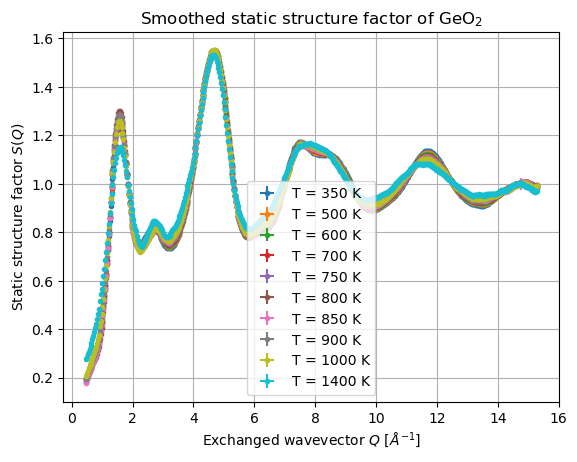

In [6]:
sdq_smoothed = sci.signal.savgol_filter(sdq,30,3)


for i in range(len(T)):
    #plt.errorbar(angle_cut,sdq, fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
    plt.errorbar(q,sdq_smoothed[i], fmt = '.', yerr = err_sdq[i], xerr= err_q,label = 'T = %d K' %T[i])
#plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.xlabel(r'Exchanged wavevector $Q$ [$\AA^{-1}$]')
plt.ylabel('Static structure factor $S(Q)$')
plt.title(r'Smoothed static structure factor of GeO$_2$')
plt.grid()
plt.legend()
plt.show()


Multiply by gaussian to reduce non-physical oscillations at high-$Q$ and reduce ripples at low-$r$

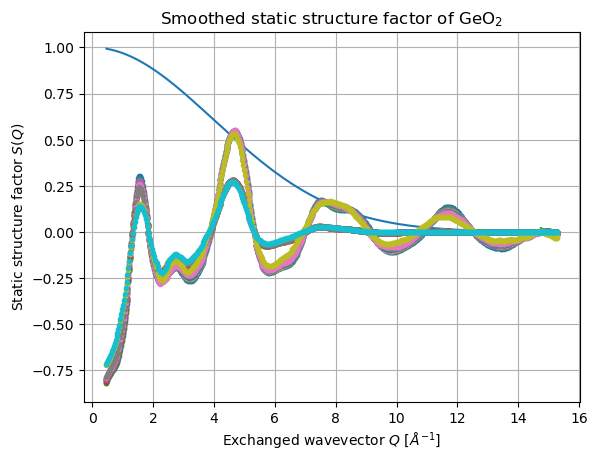

In [7]:
sigma=4
gauss = gaussian(q,1,0,sigma)


sdq_flattened = []  
err_sdq_flattened = []  
for i in range(len(T)):
   # flat = (sdq_smoothed[i]-highq_lim[i])*gauss+highq_lim[i]
   # err_flat = np.sqrt((err_sdq[i]**2+err_highq_lim[i]**2)*gauss**2+err_highq_lim[i]**2)
    flat = (sdq_smoothed[i]-1)*gauss
    err_flat = err_sdq[i]*gauss
    sdq_flattened.append(flat) 
    err_sdq_flattened.append(err_flat) 
    #plt.errorbar(angle_cut,sdq, fmt = '.', yerr = 0, xerr= err_angle,label = 'T = %d K' %T[i])
    plt.errorbar(q,sdq_smoothed[i]-1, fmt = '.', yerr = err_sdq[i], xerr= err_q,label = 'S(Q) @ T = %d K' %T[i])
    plt.errorbar(q,flat, fmt = '.', yerr = err_flat, xerr= err_q,label = 'S(Q)*gaussian @ T = %d K' %T[i])
#plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.plot(q,gauss, label = 'Gaussian')
plt.xlabel(r'Exchanged wavevector $Q$ [$\AA^{-1}$]')
plt.ylabel('Static structure factor $S(Q)$')
plt.title(r'Smoothed static structure factor of GeO$_2$')
plt.grid()
#plt.legend()
plt.show()

Finally retrieve G(r). Define $r_{min}=1/Q_{max}$ and then the $r$-mesh as $i\cdot r_{min}$ with $i=0$,length of $Q$-mesh

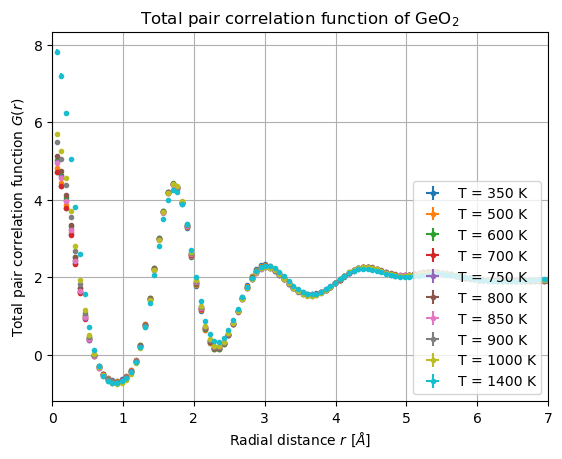

In [8]:
dr = 1/max(q)  # in Angstrom
err_dr = err_q[-1]*dr**2

r = dr*np.arange(1,len(q)+1) 
err_r = err_dr*np.arange(1,len(q)+1) 

gdr = []
err_gdr = []

A = (np.sqrt(sigma_ge_coh)+2*np.sqrt(sigma_o_coh))**2/(sigma_ge_coh+4*sigma_o_coh)

for i in range(len(T)):
    integral = np.zeros(len(r))
    err_integral = np.zeros(len(r))
    for j in range(len(r)):
        integrand = sdq_flattened[i]*q*np.sin(q*r[j])
        err_integrand = np.sqrt((err_sdq_flattened[i]*q*np.sin(q*r[j]))**2+(err_q*sdq_flattened[i]*(np.sin(q*r[j])+q*r[j]*np.cos(q*r[j])))**2)
        integral[j] = sci.integrate.simpson(integrand,q)
        err_integral[j] = (max(q)-min(q))/(3*(len(q)-1))*np.sqrt(-3*err_integrand[0]**2-15*err_integrand[-1]**2+sum(4*err_integrand[::2]**2)+sum(16*err_integrand[1::2]**2))  #propagate error form Simpson integral formula

    funz = A + 1/(2*np.pi**2*n_geo2[i]*r)*integral
    err_funz = np.sqrt((err_integral/(2*np.pi**2*n_geo2[i]*r))**2+(err_r/(2*np.pi**2*n_geo2[i]*r**2)*integral)**2)
    
    gdr.append(funz)
    err_gdr.append(err_funz)
    plt.errorbar(r,funz, fmt = '.', yerr = err_funz, xerr= err_r,label = 'T = %d K' %T[i])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Total pair correlation function $G(r)$')
plt.title(r'Total pair correlation function of GeO$_2$')
plt.xlim(0,7)
#plt.ylim(-1,10)
plt.grid()
plt.legend(loc='lower right')
plt.show()

Need to remove the contribution from the gaussian used to reduce the step towards zero at high $Q$. We know that multiplication in $Q$ space corresponds to convolution in $r$ space. By defining the Fourier transform as
$$
\mathcal{F}[f(\textbf{r})] = \int d\textbf{r} f(\textbf{r}) e^{i \textbf{Q} \cdot \textbf{r}} \underset{f(\textbf{r})=f(r)}{=} \frac{4 \pi}{Q} \int_0^{\infty}dr f(r) r \sin(qr)\\
f(\textbf{r}) = \frac{1}{(2 \pi)^3}\int d\textbf{Q} \mathcal{F}[f(\textbf{r})] e^{-i \textbf{Q} \cdot \textbf{r}} \underset{f(\textbf{r})=f(r)}{=} \frac{1}{2 \pi^2r } \int_0^{\infty} dQ \mathcal{F}[f(\textbf{r})] Q \sin(Qr) dQ
$$

The convolution formula reads
$$
 \mathcal{F}[f(\textbf{r}) \ast g(\textbf{r})] =   \mathcal{F}[f(\textbf{r})] \mathcal{F}[g(\textbf{r})] \Rightarrow f(\textbf{r}) \ast g(\textbf{r}) = \frac{1}{(2 \pi)^3} \int d\textbf{Q} \mathcal{F}[f(\textbf{r})]  \mathcal{F}[g(\textbf{r})] 
$$

Then, given the Fourier couple $\left \{\frac{1}{n_{GeO_2}}\left[S(Q)-1\right], \left[g(r)-1\right]\right \}$ the multiplication by $\exp(-Q^2/2\sigma^2)$ in the inverse Fourier transform gives back
$$
\left[g(r)-1\right] \ast \mathcal{F}^{-1}[e^{-Q^2/2\sigma^2}] = \frac{1}{2 \pi^2 r} \int_0^{\infty}\frac{1}{n_{GeO_2}}\left[S(Q)-1\right]e^{-Q^2/2\sigma^2}Q\sin(Qr)dQ
$$ 

where $\mathcal{F}^{-1}[e^{-Q^2/2\sigma^2}]  = \left(\frac{\sigma^2}{2 \pi}\right)^{3/2}e^{-\sigma^2 r^2/2}$. Then in order to retrieve the actual $g(r)$ this function needs to be deconvolved from the inverse Fourier transform result

In [9]:
# Define gaussian convoluted
gauss_conv= gaussian(r,(sigma**2/(2*np.pi))**3/2,0,1/sigma)

# Need to underdstand how to deconvolve in Python...
'''
for i in range (len(T)):
    plt.errorbar(r, gdr[i],yerr= err_gdr[i], fmt = '*', label = 'Original @ T = %8.0f' %T[i])

    gdr[i] = 1 + sci.signal.deconvolve(np.array(gdr[i]-1), gauss_conv)[1]

    plt.errorbar(r, gdr[i],yerr= err_gdr[i], fmt = '.', label = 'Deconvolved @ T = %8.0f' %T[i])

plt.plot(r, gauss_conv, '.', label = 'Gaussian')
plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Total pair correlation function $G(r)$')
plt.title(r'Deconvolve the gaussian')
plt.xlim(0,7)
plt.ylim(-2,4)
plt.grid()
plt.legend(loc='lower right')
plt.show()'''

"\nfor i in range (len(T)):\n    plt.errorbar(r, gdr[i],yerr= err_gdr[i], fmt = '*', label = 'Original @ T = %8.0f' %T[i])\n\n    gdr[i] = 1 + sci.signal.deconvolve(np.array(gdr[i]-1), gauss_conv)[1]\n\n    plt.errorbar(r, gdr[i],yerr= err_gdr[i], fmt = '.', label = 'Deconvolved @ T = %8.0f' %T[i])\n\nplt.plot(r, gauss_conv, '.', label = 'Gaussian')\nplt.xlabel(r'Radial distance $r$ [$\\AA$]')\nplt.ylabel('Total pair correlation function $G(r)$')\nplt.title(r'Deconvolve the gaussian')\nplt.xlim(0,7)\nplt.ylim(-2,4)\nplt.grid()\nplt.legend(loc='lower right')\nplt.show()"

In [10]:
'''a = np.arange(0, 50, 0.1)
b = gaussian(a[0:11],1,0,10)

aconvolved = sci.signal.convolve(np.sin(a), b, mode='same')
adeconvolved = sci.signal.deconvolve(aconvolved, b)[0]

n = len(a)-len(b)+1
print(n)
# so we need to expand it by 
s = int((len(a)-n)/2)
#on both sides.
deconv_res = np.zeros(len(a))
#deconv_res[s:len(a)-s-1] = adeconvolved
#adeconvolved = deconv_res

plt.figure()
plt.plot(a, np.sin(a), '.',label = 'original')
#plt.plot(a, aconvolved,'.', label = 'convolved') 
plt.plot(a[5:-5], adeconvolved,'.', label = 'deconvolved')
plt.legend()
plt.draw()'''

"a = np.arange(0, 50, 0.1)\nb = gaussian(a[0:11],1,0,10)\n\naconvolved = sci.signal.convolve(np.sin(a), b, mode='same')\nadeconvolved = sci.signal.deconvolve(aconvolved, b)[0]\n\nn = len(a)-len(b)+1\nprint(n)\n# so we need to expand it by \ns = int((len(a)-n)/2)\n#on both sides.\ndeconv_res = np.zeros(len(a))\n#deconv_res[s:len(a)-s-1] = adeconvolved\n#adeconvolved = deconv_res\n\nplt.figure()\nplt.plot(a, np.sin(a), '.',label = 'original')\n#plt.plot(a, aconvolved,'.', label = 'convolved') \nplt.plot(a[5:-5], adeconvolved,'.', label = 'deconvolved')\nplt.legend()\nplt.draw()"

Remove unphysical oscillations at low $r$

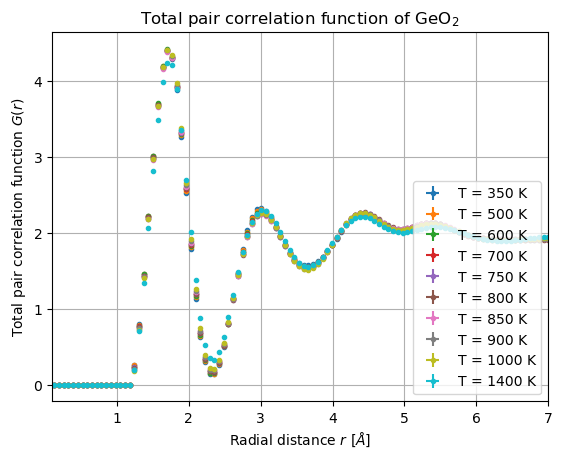

In [11]:
# Set non physical oscillations at low r to zero

def process_matrix(matrix,err_matrix):
    # Convert the input to a NumPy array if it isn't already
    matrix = np.array(matrix)
    err_matrix=np.array(err_matrix)
    
    # Get the shape of the matrix
    rows, _ = matrix.shape
    
    # Iterate over each row
    for i in range(rows):
        # Find indices of negative elements in the row
        negative_indices = np.where(matrix[i] < 0)[0]
        
        if len(negative_indices) > 0:
            # Get the index of the negative element with the highest index
            highest_index = negative_indices[-1]
            # Set all elements before this index to zero
            matrix[i, :(highest_index+1)] = 0
            err_matrix[i, :(highest_index+1)] = 0
    
    return matrix, err_matrix

gdr, err_gdr = process_matrix(gdr,err_gdr)

for i in range(len(T)):
    plt.errorbar(r,gdr[i], fmt = '.', yerr = err_gdr[i], xerr= err_r,label = 'T = %d K' %T[i])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Total pair correlation function $G(r)$')
plt.title(r'Total pair correlation function of GeO$_2$')
plt.xlim(0.1,7)
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Peak evolution in $T$ analysis

Find $S(Q)$ peaks position

######## Peaks positions #########
 1.54 1/Å
 2.6 1/Å
 ~4.5 Å
################
######## T =      350  K ########


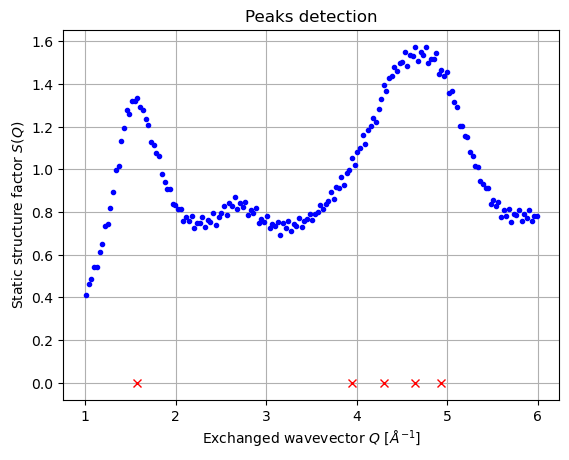

Peak 1 fit parameters
Peak position 1.585 +/- 0.004 Å
Peak height 1.31 +/- 0.01
Peak width 0.336 +/- 0.006 Å
Chi squared/dof 39.11369467676914
Peak 2 fit parameters
Peak position 2.68 +/- 0.02 Å
Peak height 0.836 +/- 0.008
Peak width 0.62 +/- 0.08 Å
Chi squared/dof 16.880434510080246
Peak 3 fit parameters
Peak position 4.663 +/- 0.005 Å
Peak height 1.548 +/- 0.007
Peak width 0.73 +/- 0.01 Å
Chi squared/dof 27.36476927501001


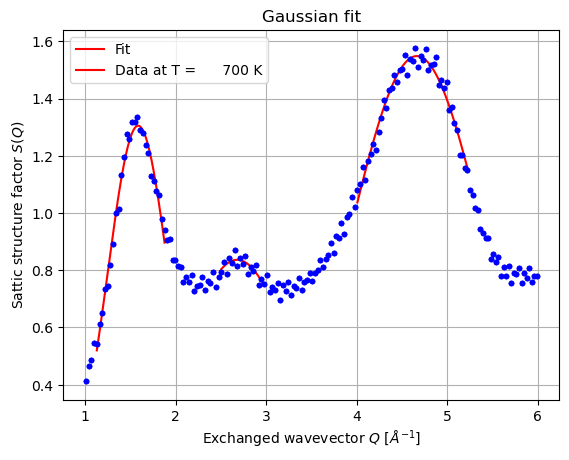

######## T =      500  K ########


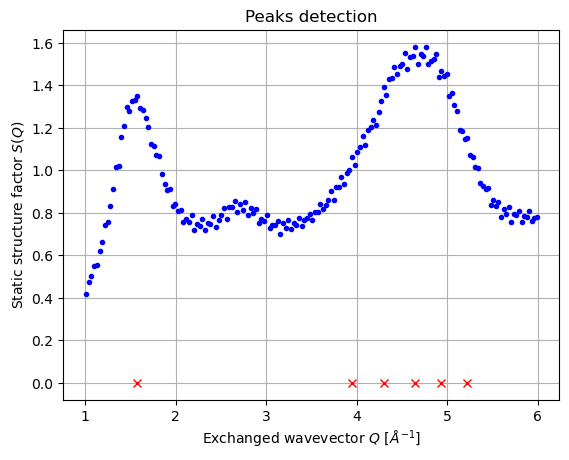

Peak 1 fit parameters
Peak position 1.581 +/- 0.004 Å
Peak height 1.32 +/- 0.01
Peak width 0.336 +/- 0.006 Å
Chi squared/dof 41.62255435577262
Peak 2 fit parameters
Peak position 2.69 +/- 0.02 Å
Peak height 0.833 +/- 0.008
Peak width 0.62 +/- 0.08 Å
Chi squared/dof 15.23163793742522
Peak 3 fit parameters
Peak position 4.66 +/- 0.006 Å
Peak height 1.546 +/- 0.008
Peak width 0.73 +/- 0.01 Å
Chi squared/dof 32.3286086638374


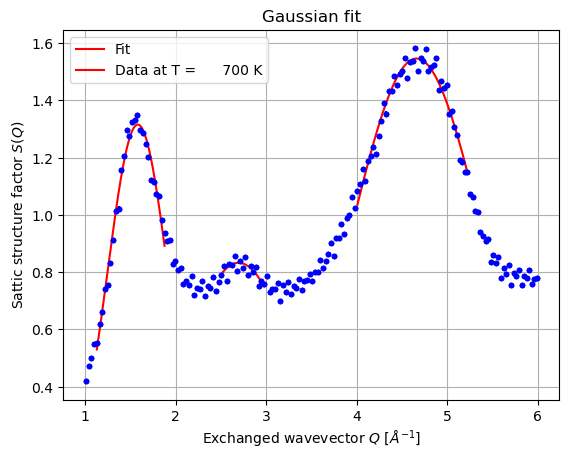

######## T =      600  K ########


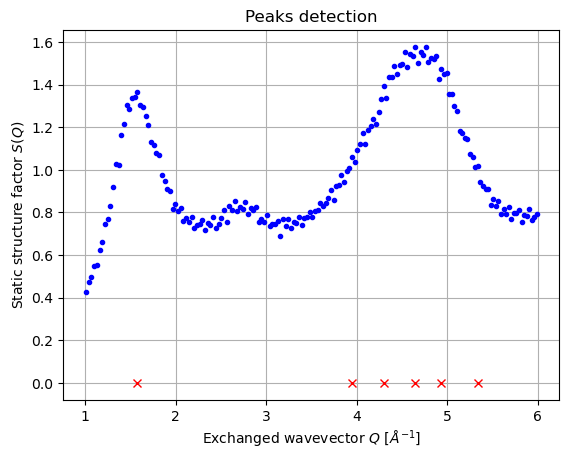

Peak 1 fit parameters
Peak position 1.581 +/- 0.005 Å
Peak height 1.32 +/- 0.01
Peak width 0.335 +/- 0.007 Å
Chi squared/dof 44.498619811693615
Peak 2 fit parameters
Peak position 2.72 +/- 0.02 Å
Peak height 0.828 +/- 0.008
Peak width 0.6 +/- 0.08 Å
Chi squared/dof 16.922055906947612
Peak 3 fit parameters
Peak position 4.655 +/- 0.006 Å
Peak height 1.545 +/- 0.009
Peak width 0.73 +/- 0.01 Å
Chi squared/dof 36.73595707055242


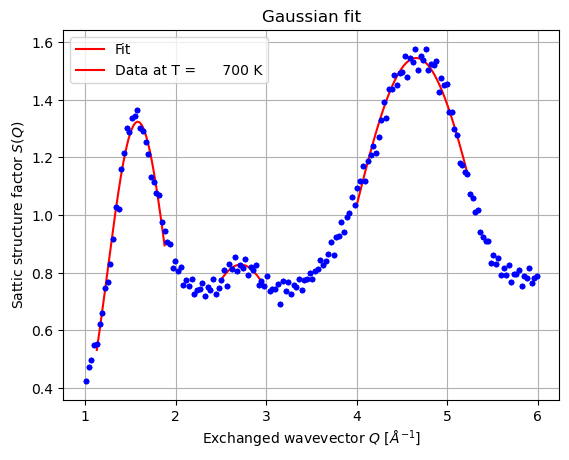

######## T =      700  K ########


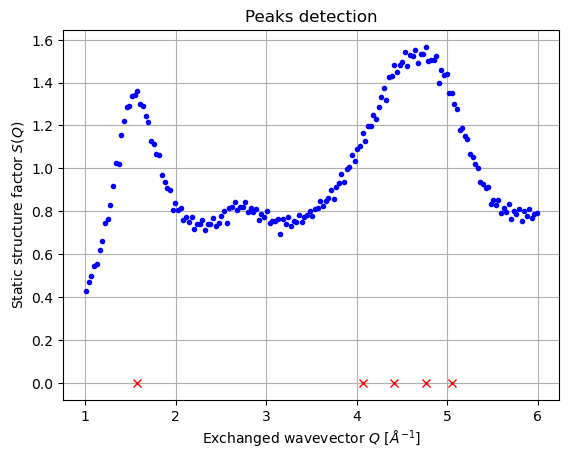

Peak 1 fit parameters
Peak position 1.579 +/- 0.004 Å
Peak height 1.33 +/- 0.01
Peak width 0.332 +/- 0.006 Å
Chi squared/dof 39.797119131545735
Peak 2 fit parameters
Peak position 2.73 +/- 0.02 Å
Peak height 0.821 +/- 0.007
Peak width 0.67 +/- 0.09 Å
Chi squared/dof 13.281522890675662
Peak 3 fit parameters
Peak position 4.653 +/- 0.006 Å
Peak height 1.538 +/- 0.007
Peak width 0.74 +/- 0.01 Å
Chi squared/dof 30.19702637143691


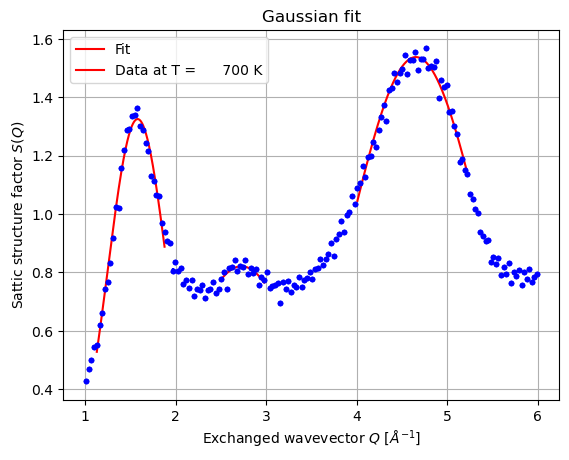

######## T =      750  K ########


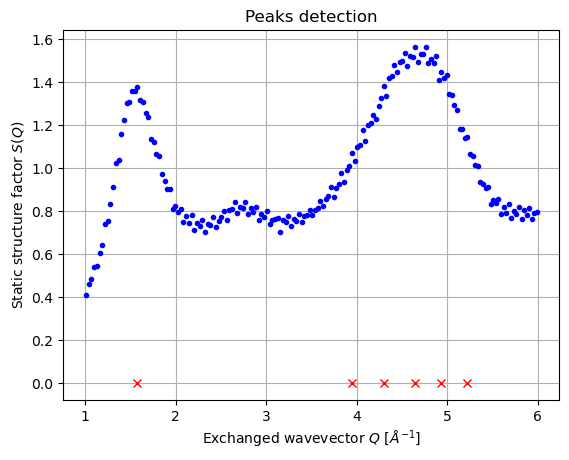

Peak 1 fit parameters
Peak position 1.58 +/- 0.004 Å
Peak height 1.34 +/- 0.01
Peak width 0.326 +/- 0.006 Å
Chi squared/dof 40.86412933760215
Peak 2 fit parameters
Peak position 2.73 +/- 0.02 Å
Peak height 0.816 +/- 0.007
Peak width -0.7 +/- 0.1 Å
Chi squared/dof 13.430702795065548
Peak 3 fit parameters
Peak position 4.652 +/- 0.006 Å
Peak height 1.535 +/- 0.007
Peak width 0.74 +/- 0.01 Å
Chi squared/dof 30.303304566766492


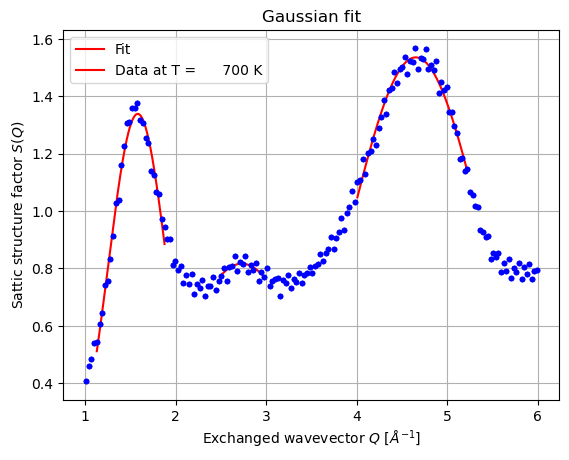

######## T =      800  K ########


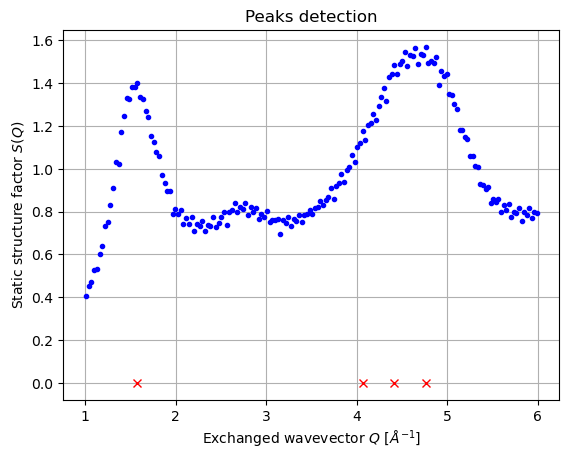

Peak 1 fit parameters
Peak position 1.578 +/- 0.004 Å
Peak height 1.36 +/- 0.01
Peak width 0.318 +/- 0.006 Å
Chi squared/dof 41.76779052397885
Peak 2 fit parameters
Peak position 2.75 +/- 0.02 Å
Peak height 0.813 +/- 0.008
Peak width 0.7 +/- 0.1 Å
Chi squared/dof 12.967544701312182
Peak 3 fit parameters
Peak position 4.652 +/- 0.006 Å
Peak height 1.537 +/- 0.008
Peak width 0.74 +/- 0.01 Å
Chi squared/dof 33.697009915175656


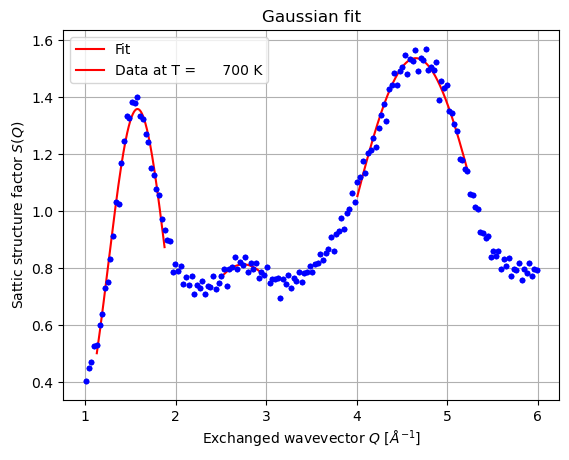

######## T =      850  K ########


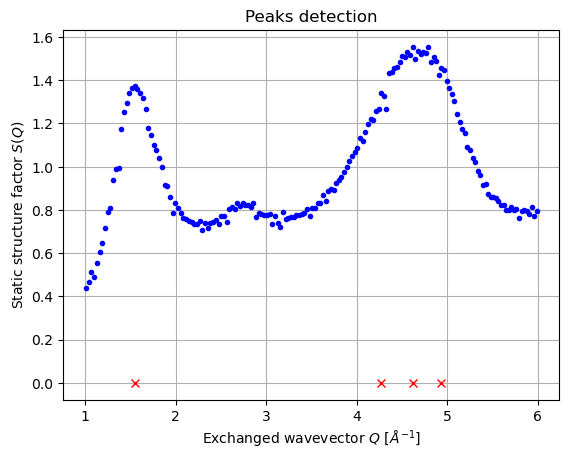

Peak 1 fit parameters
Peak position 1.577 +/- 0.005 Å
Peak height 1.35 +/- 0.01
Peak width 0.32 +/- 0.007 Å
Chi squared/dof 21.901175443598333
Peak 2 fit parameters
Peak position 2.74 +/- 0.01 Å
Peak height 0.824 +/- 0.005
Peak width 0.61 +/- 0.06 Å
Chi squared/dof 3.312488242427167
Peak 3 fit parameters
Peak position 4.652 +/- 0.006 Å
Peak height 1.531 +/- 0.008
Peak width 0.74 +/- 0.01 Å
Chi squared/dof 11.476748812784628


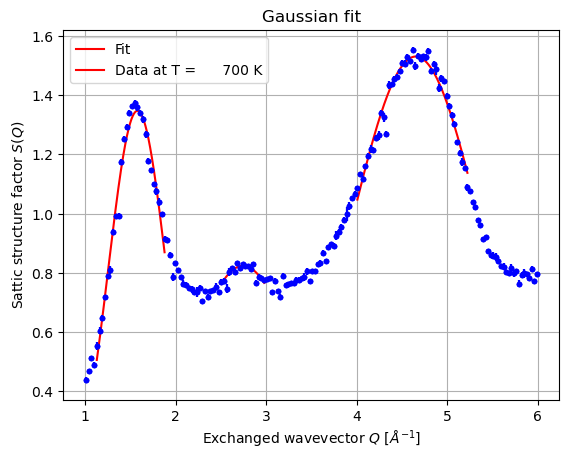

######## T =      900  K ########


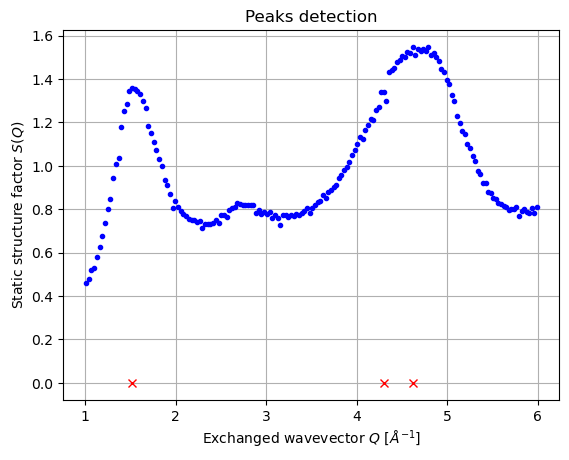

Peak 1 fit parameters
Peak position 1.577 +/- 0.004 Å
Peak height 1.33 +/- 0.01
Peak width 0.333 +/- 0.006 Å
Chi squared/dof 41.017165490406924
Peak 2 fit parameters
Peak position 2.753 +/- 0.009 Å
Peak height 0.822 +/- 0.003
Peak width 0.64 +/- 0.04 Å
Chi squared/dof 3.216540196328815
Peak 3 fit parameters
Peak position 4.649 +/- 0.005 Å
Peak height 1.539 +/- 0.007
Peak width 0.73 +/- 0.01 Å
Chi squared/dof 22.701253618098274


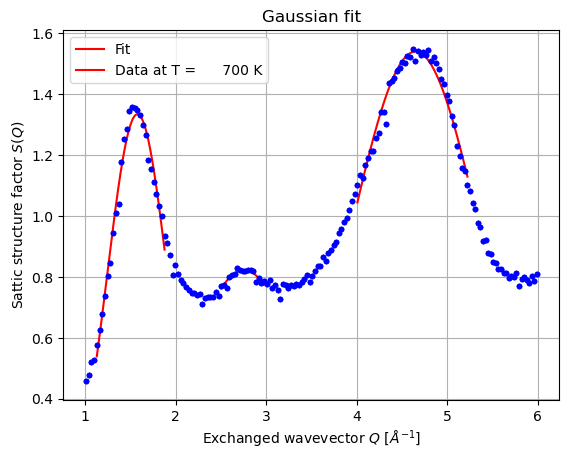

######## T =     1000  K ########


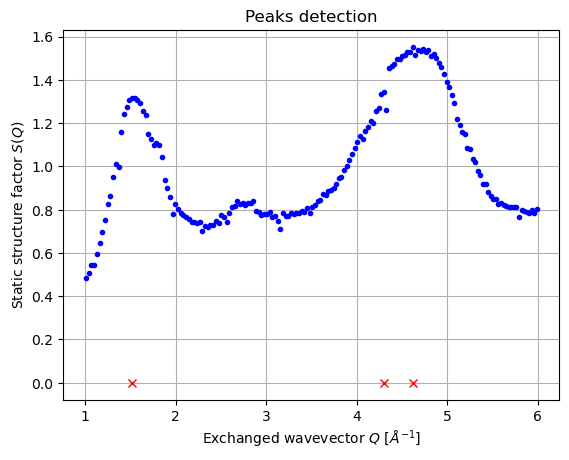

Peak 1 fit parameters
Peak position 1.578 +/- 0.006 Å
Peak height 1.3 +/- 0.01
Peak width 0.35 +/- 0.008 Å
Chi squared/dof 45.50377570965512
Peak 2 fit parameters
Peak position 2.75 +/- 0.01 Å
Peak height 0.831 +/- 0.006
Peak width 0.57 +/- 0.04 Å
Chi squared/dof 7.563070301302325
Peak 3 fit parameters
Peak position 4.645 +/- 0.006 Å
Peak height 1.543 +/- 0.008
Peak width 0.72 +/- 0.01 Å
Chi squared/dof 33.849941303238225


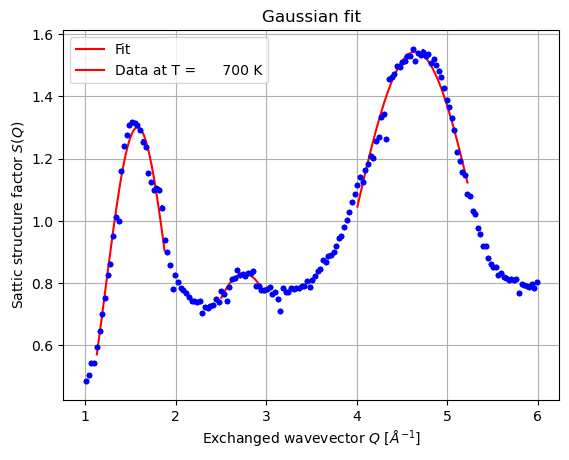

######## T =     1400  K ########


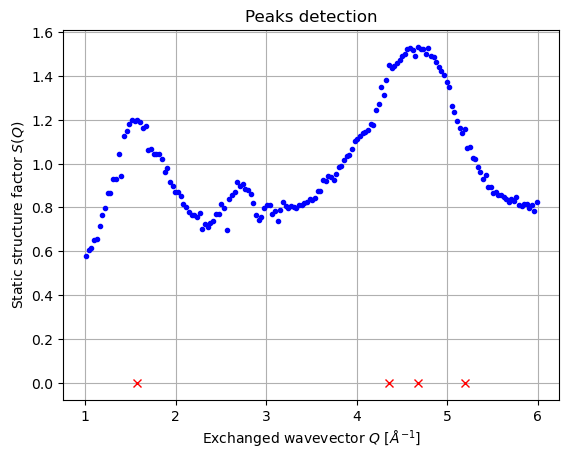

Peak 1 fit parameters
Peak position 1.599 +/- 0.009 Å
Peak height 1.17 +/- 0.01
Peak width 0.44 +/- 0.02 Å
Chi squared/dof 26.39335277548987
Peak 2 fit parameters
Peak position 2.72 +/- 0.02 Å
Peak height 0.89 +/- 0.01
Peak width 0.42 +/- 0.05 Å
Chi squared/dof 33.55163509776015
Peak 3 fit parameters
Peak position 4.636 +/- 0.005 Å
Peak height 1.523 +/- 0.009
Peak width 0.72 +/- 0.01 Å
Chi squared/dof 16.250380161988133


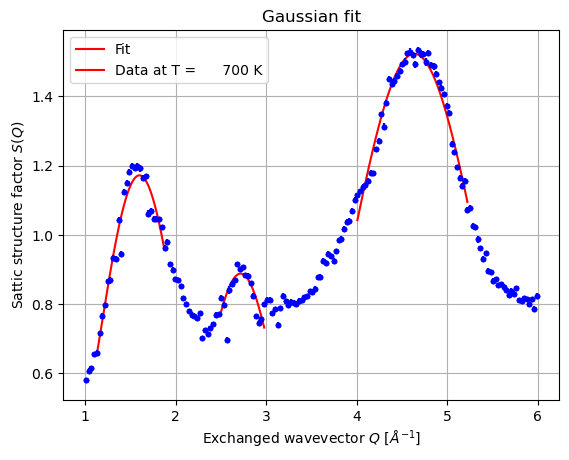

In [12]:
peak_label = ['Peak 1', 'Peak 2', 'Peak 3']
sdq_peaks_tot = []
delta_sdq_peaks_tot = []  
height_sdq_peaks_tot = []
delta_height_sdq_peaks_tot = []
width_sdq_peaks_tot = []
delta_width_sdq_peaks_tot = []

print('######## Peaks positions #########')
print(' 1.54 1/Å')
print(' 2.6 1/Å')
print(' ~4.5 Å')
print('################')

for i in range(len(T)):

    print('######## T = %8.0f  K ########' % T[i] )

    index = get_indices_in_range(q,1,6)
    shift = q[index]
    intensity = sdq[i][index]
    err_intensity = err_sdq[i][index]
    
    index_peaks = sci.signal.find_peaks(intensity,height=1,distance=10)[0]
    widths = sci.signal.peak_widths(intensity,index_peaks, rel_height=0.0035)[0]

    shift_peak= []
    intensity_peaks = []

    i=0
    while(i<index_peaks.size):
        shift_peak.append(shift[index_peaks[i]])
        intensity_peaks.append(intensity[index_peaks[i]])
        i=i+1

    larghezza_in_shift = widths*2
    #print(shift_peak,larghezza_in_shift)


    shift_peak = np.array(shift_peak) 

    plt.plot(shift,intensity,'.',color='blue')
    plt.plot(shift_peak,[0]*len(shift_peak),'x',color='red')
    plt.title('Peaks detection')
    plt.xlabel(r'Exchanged wavevector $Q$ [$Å^{-1}$]')
    plt.ylabel(r'Static structure factor $S(Q)$')
    plt.grid()
    plt.show()


    ranges = []
    for j in range(len(shift_peak)):
        shift_sup = shift_peak[j]+larghezza_in_shift[j]/2
        shift_inf = shift_peak[j]-larghezza_in_shift[j]/2
        coord = (shift_inf,shift_sup)
        ranges.append(coord)

    sdq_peaks = []
    delta_sdq_peaks = []  
    height_sdq_peaks = []
    delta_height_sdq_peaks = []
    width_sdq_peaks = []
    delta_width_sdq_peaks = []

    ranges = [[1.1,1.9],[2.5,3],[4,5.25]]  #serve modo per automatizzare --> se fallisce il fit rifallo su più/meno punti finchè non viene [1.4,2],[2.7,3.4],[4,4.75]
    i = 0
    for start, end in ranges:

        x_indices = get_indices_in_range(shift, start, end)
        first_peak_x = shift[x_indices]
        first_peak_y = intensity[x_indices]
        sigma =err_intensity[x_indices]

        #p0 = [max(first_peak_y), np.mean(first_peak_x), 1]
        popt, pcov = curve_fit(gaussian,first_peak_x, first_peak_y,sigma=sigma,maxfev=80000)  # ,bounds=([min(first_peak_y),min(first_peak_x),0.1],[2*max(first_peak_y),max(first_peak_x),2*abs(max(first_peak_x)-min(first_peak_x))])
        chi_sq = np.sum((first_peak_y-gaussian(first_peak_x, *popt))**2/sigma**2)/(np.size(first_peak_y)-3)
        print( peak_label[i],'fit parameters')
        par = my_round(popt,np.sqrt(np.diag(pcov)))
        print('Peak position',par[1][0], '+/-', par[1][1],'Å')
        print('Peak height',par[0][0], '+/-', par[0][1])
        print('Peak width', par[2][0], '+/-', par[2][1], 'Å')
        print('Chi squared/dof', chi_sq)
    
        sdq_peaks.append(popt[1])
        height_sdq_peaks.append(popt[0])
        width_sdq_peaks.append(popt[2])

        delta_sdq_peaks.append(np.sqrt(pcov[1][1]) )
        delta_height_sdq_peaks.append(np.sqrt(pcov[0][0]))
        delta_width_sdq_peaks.append(np.sqrt(pcov[2][2]))

        i +=1
        x_plot = np.linspace(min(first_peak_x), max(first_peak_x),10000)
        plt.plot(x_plot, gaussian(x_plot, *popt),color='red')
        plt.errorbar(shift,intensity,yerr=err_intensity,fmt='.',color='blue')
    plt.title('Gaussian fit')
    plt.legend(['Fit', 'Data at T = %8.0f K' % T[i]])
    plt.grid()
    plt.xlabel(r'Exchanged wavevector $Q$ [$Å^{-1}$]')
    plt.ylabel(r'Sattic structure factor $S(Q)$')
    plt.show()

    sdq_peaks_tot.append(sdq_peaks)
    delta_sdq_peaks_tot.append(delta_sdq_peaks) 
    height_sdq_peaks_tot.append(height_sdq_peaks)
    delta_height_sdq_peaks_tot.append(delta_height_sdq_peaks)
    width_sdq_peaks_tot.append(width_sdq_peaks)
    delta_width_sdq_peaks_tot.append(delta_width_sdq_peaks)

sdq_peaks_tot=np.array(sdq_peaks_tot)
delta_sdq_peaks_tot=np.array(delta_sdq_peaks_tot)
height_sdq_peaks_tot=np.array(height_sdq_peaks_tot)
delta_height_sdq_peaks_tot=np.array(delta_height_sdq_peaks_tot)
width_sdq_peaks_tot=np.array(width_sdq_peaks_tot)
delta_width_sdq_peaks_tot=np.array(delta_width_sdq_peaks_tot)

Find the $G(r)$ peaks position

######## Nearest neighbours distances #########
Ge-O: 1.73 Å
O-O: 2.82 Å
Ge-Ge: 3.16 Å
################
######## T =      350  K ########


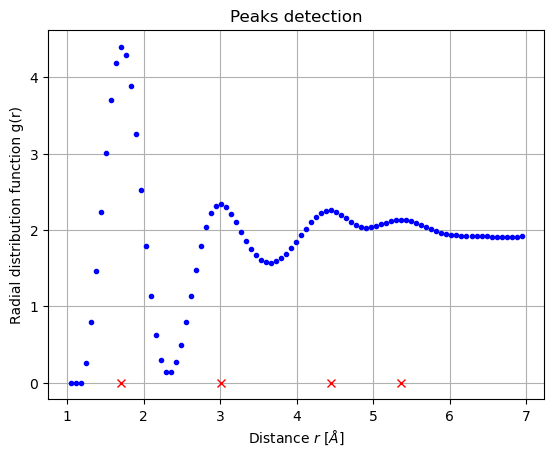

Peak 1 fit parameters
Peak position 1.714 +/- 0.001 Å
Peak height 4.43 +/- 0.02
Peak width 0.233 +/- 0.001 Å
Chi squared/dof 59.51852543678577
Peak 2 fit parameters
Peak position 3.035 +/- 0.007 Å
Peak height 2.32 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 331.882440253001
Peak 3 fit parameters
Peak position 4.444 +/- 0.003 Å
Peak height 2.254 +/- 0.004
Peak width 0.69 +/- 0.01 Å
Chi squared/dof 27.39916734924407
Peak 4 fit parameters
Peak position 5.36 +/- 0.02 Å
Peak height 2.119 +/- 0.005
Peak width 1.36 +/- 0.06 Å
Chi squared/dof 98.11890778071923


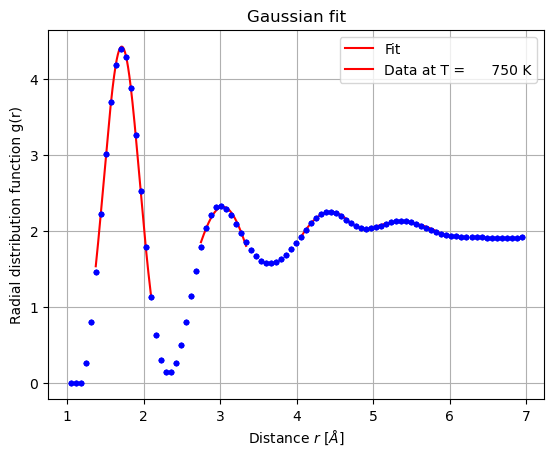

######## T =      500  K ########


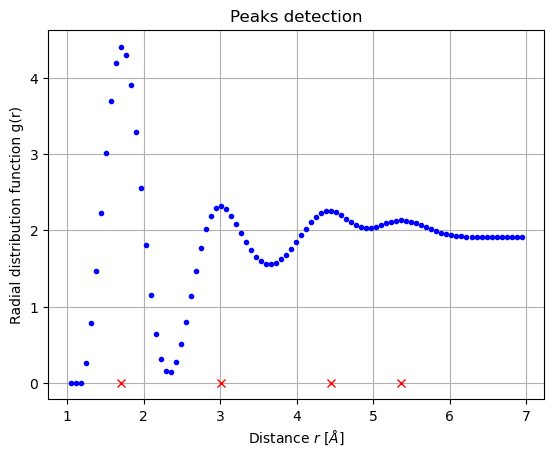

Peak 1 fit parameters
Peak position 1.715 +/- 0.001 Å
Peak height 4.45 +/- 0.02
Peak width 0.233 +/- 0.001 Å
Chi squared/dof 55.96531053544467
Peak 2 fit parameters
Peak position 3.037 +/- 0.007 Å
Peak height 2.3 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 275.93433391985764
Peak 3 fit parameters
Peak position 4.444 +/- 0.004 Å
Peak height 2.257 +/- 0.004
Peak width 0.7 +/- 0.01 Å
Chi squared/dof 25.309219668074483
Peak 4 fit parameters
Peak position 5.36 +/- 0.02 Å
Peak height 2.119 +/- 0.005
Peak width 1.36 +/- 0.06 Å
Chi squared/dof 78.68628078883182


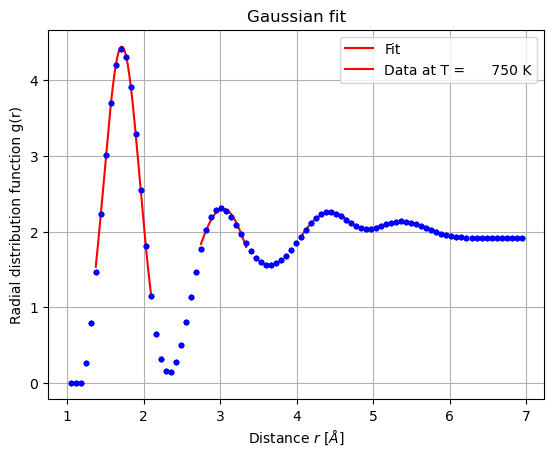

######## T =      600  K ########


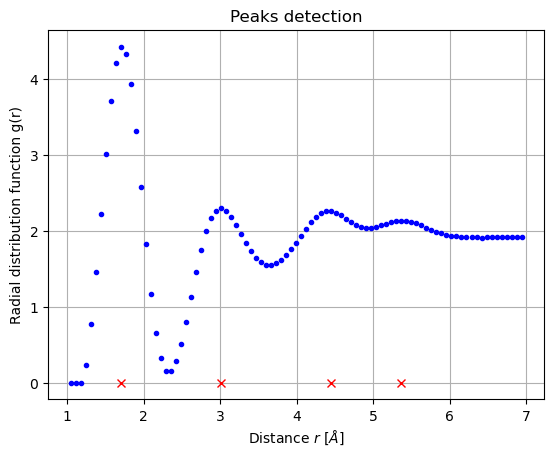

Peak 1 fit parameters
Peak position 1.716 +/- 0.001 Å
Peak height 4.46 +/- 0.02
Peak width 0.234 +/- 0.001 Å
Chi squared/dof 59.28417919575296
Peak 2 fit parameters
Peak position 3.04 +/- 0.007 Å
Peak height 2.28 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 252.48682768588642
Peak 3 fit parameters
Peak position 4.444 +/- 0.004 Å
Peak height 2.261 +/- 0.004
Peak width 0.7 +/- 0.01 Å
Chi squared/dof 26.089295592913054
Peak 4 fit parameters
Peak position 5.37 +/- 0.02 Å
Peak height 2.12 +/- 0.005
Peak width 1.36 +/- 0.06 Å
Chi squared/dof 69.82105277624399


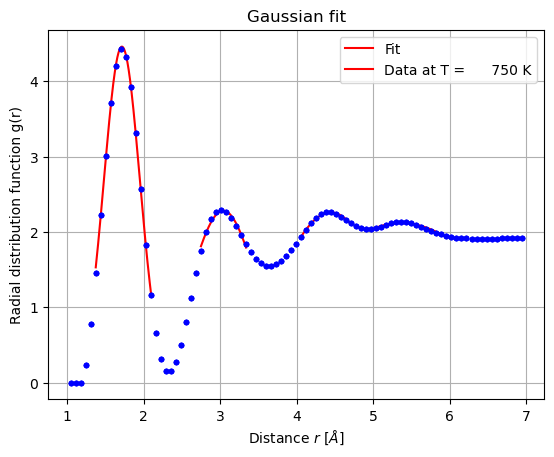

######## T =      700  K ########


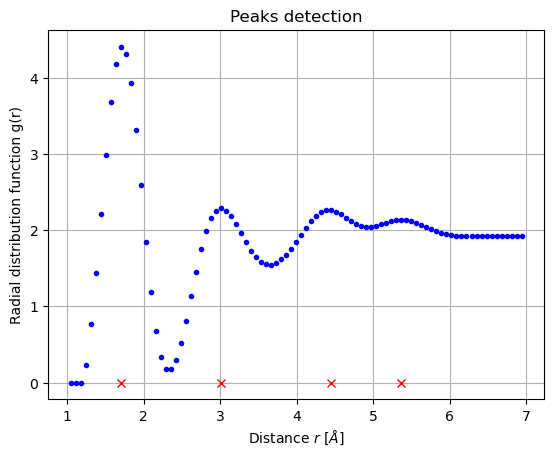

Peak 1 fit parameters
Peak position 1.718 +/- 0.001 Å
Peak height 4.44 +/- 0.02
Peak width 0.234 +/- 0.001 Å
Chi squared/dof 58.46854895582649
Peak 2 fit parameters
Peak position 3.042 +/- 0.006 Å
Peak height 2.27 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 237.50547184616653
Peak 3 fit parameters
Peak position 4.447 +/- 0.004 Å
Peak height 2.261 +/- 0.004
Peak width 0.71 +/- 0.01 Å
Chi squared/dof 24.76767544516812
Peak 4 fit parameters
Peak position 5.35 +/- 0.02 Å
Peak height 2.117 +/- 0.005
Peak width 1.4 +/- 0.06 Å
Chi squared/dof 70.79718861746638


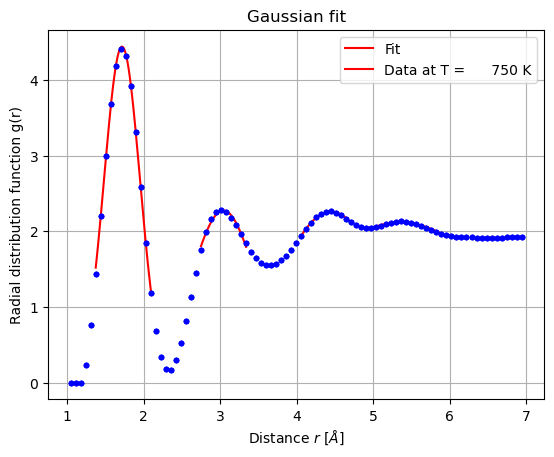

######## T =      750  K ########


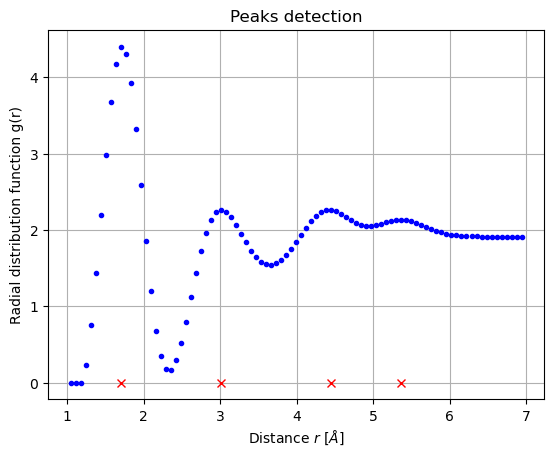

Peak 1 fit parameters
Peak position 1.718 +/- 0.001 Å
Peak height 4.44 +/- 0.02
Peak width 0.234 +/- 0.001 Å
Chi squared/dof 60.60988077129938
Peak 2 fit parameters
Peak position 3.045 +/- 0.006 Å
Peak height 2.26 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 226.0666753921871
Peak 3 fit parameters
Peak position 4.451 +/- 0.004 Å
Peak height 2.265 +/- 0.004
Peak width 0.71 +/- 0.01 Å
Chi squared/dof 23.770380736007958
Peak 4 fit parameters
Peak position 5.35 +/- 0.02 Å
Peak height 2.119 +/- 0.004
Peak width 1.42 +/- 0.06 Å
Chi squared/dof 66.40409750933712


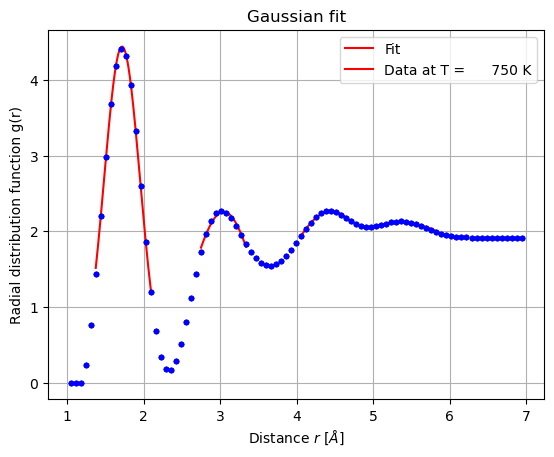

######## T =      800  K ########


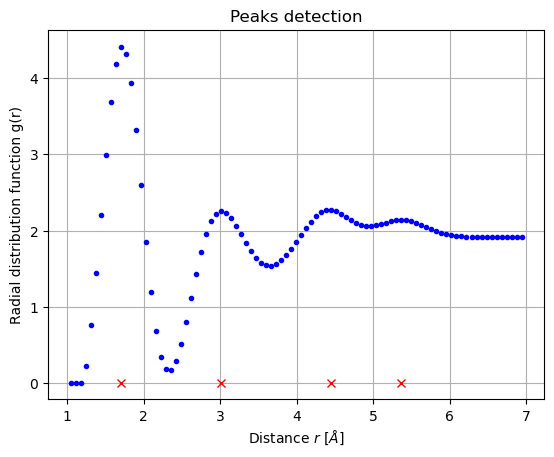

Peak 1 fit parameters
Peak position 1.718 +/- 0.001 Å
Peak height 4.45 +/- 0.02
Peak width 0.234 +/- 0.001 Å
Chi squared/dof 55.888208856745095
Peak 2 fit parameters
Peak position 3.047 +/- 0.006 Å
Peak height 2.25 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 193.17726908392584
Peak 3 fit parameters
Peak position 4.453 +/- 0.004 Å
Peak height 2.273 +/- 0.004
Peak width 0.71 +/- 0.01 Å
Chi squared/dof 21.37346798743617
Peak 4 fit parameters
Peak position 5.34 +/- 0.02 Å
Peak height 2.125 +/- 0.004
Peak width 1.41 +/- 0.06 Å
Chi squared/dof 60.23469411394953


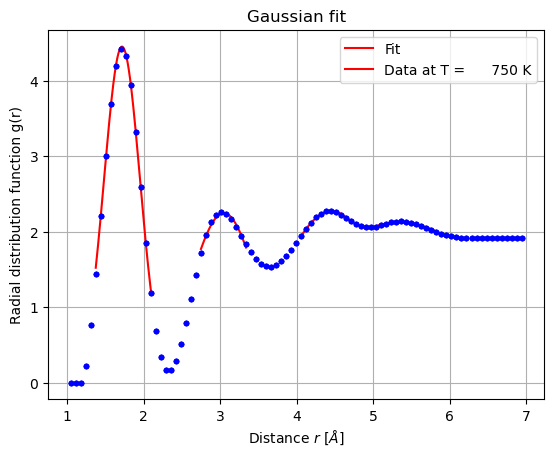

######## T =      850  K ########


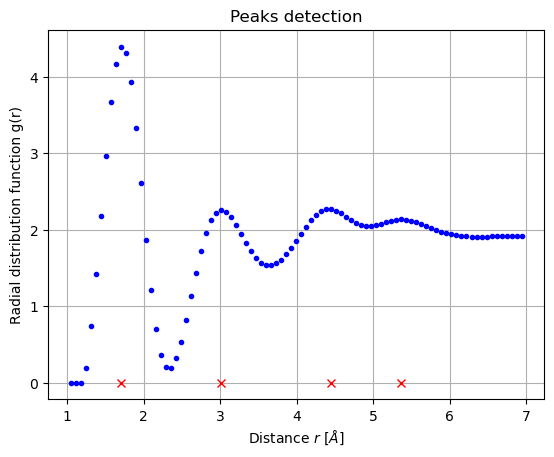

Peak 1 fit parameters
Peak position 1.719 +/- 0.001 Å
Peak height 4.43 +/- 0.02
Peak width 0.235 +/- 0.001 Å
Chi squared/dof 18.872390596414796
Peak 2 fit parameters
Peak position 3.046 +/- 0.006 Å
Peak height 2.24 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 58.2858490533347
Peak 3 fit parameters
Peak position 4.446 +/- 0.004 Å
Peak height 2.267 +/- 0.004
Peak width 0.71 +/- 0.01 Å
Chi squared/dof 8.063090497563055
Peak 4 fit parameters
Peak position 5.36 +/- 0.02 Å
Peak height 2.123 +/- 0.004
Peak width 1.39 +/- 0.05 Å
Chi squared/dof 18.604190511797338


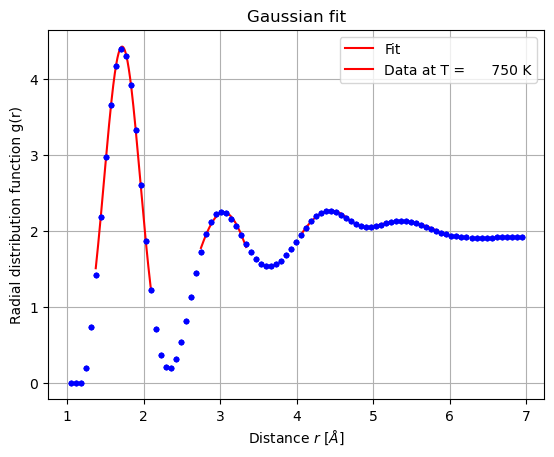

######## T =      900  K ########


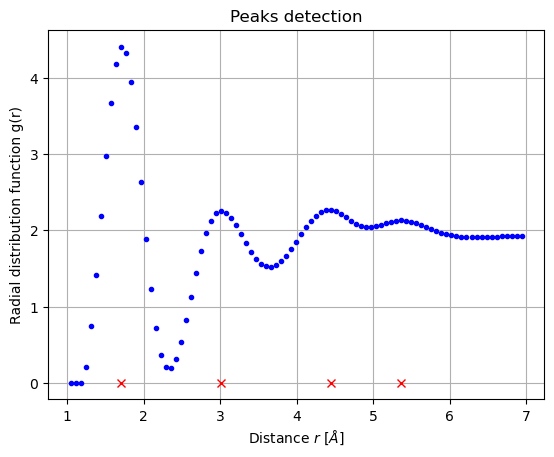

Peak 1 fit parameters
Peak position 1.72 +/- 0.001 Å
Peak height 4.45 +/- 0.02
Peak width 0.235 +/- 0.001 Å
Chi squared/dof 60.409463688154624
Peak 2 fit parameters
Peak position 3.045 +/- 0.006 Å
Peak height 2.25 +/- 0.02
Peak width 0.43 +/- 0.02 Å
Chi squared/dof 186.64949813424246
Peak 3 fit parameters
Peak position 4.444 +/- 0.004 Å
Peak height 2.269 +/- 0.004
Peak width 0.7 +/- 0.01 Å
Chi squared/dof 26.41899951800601
Peak 4 fit parameters
Peak position 5.37 +/- 0.01 Å
Peak height 2.118 +/- 0.004
Peak width 1.38 +/- 0.05 Å
Chi squared/dof 55.726331194768285


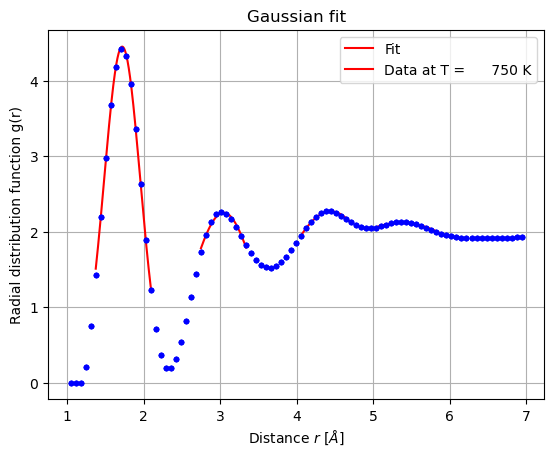

######## T =     1000  K ########


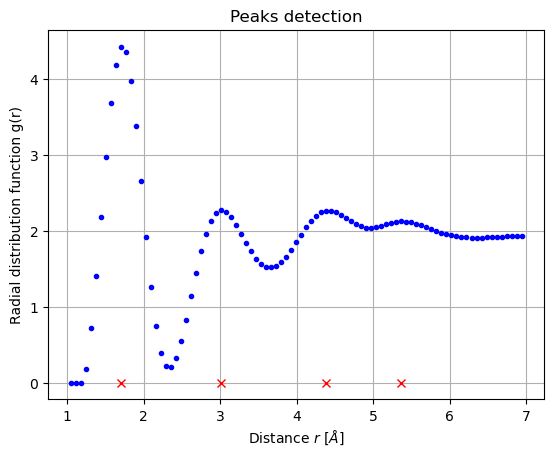

Peak 1 fit parameters
Peak position 1.722 +/- 0.001 Å
Peak height 4.46 +/- 0.02
Peak width 0.236 +/- 0.001 Å
Chi squared/dof 68.1270945417959
Peak 2 fit parameters
Peak position 3.047 +/- 0.006 Å
Peak height 2.26 +/- 0.02
Peak width 0.43 +/- 0.01 Å
Chi squared/dof 176.24853487948693
Peak 3 fit parameters
Peak position 4.442 +/- 0.004 Å
Peak height 2.266 +/- 0.005
Peak width 0.7 +/- 0.01 Å
Chi squared/dof 30.897631423957353
Peak 4 fit parameters
Peak position 5.38 +/- 0.01 Å
Peak height 2.111 +/- 0.004
Peak width 1.4 +/- 0.05 Å
Chi squared/dof 43.1199210721659


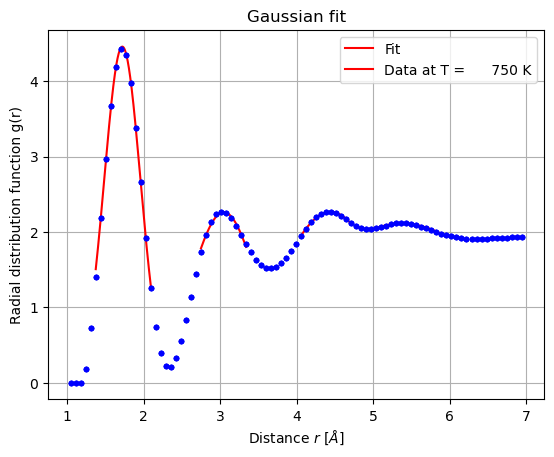

######## T =     1400  K ########


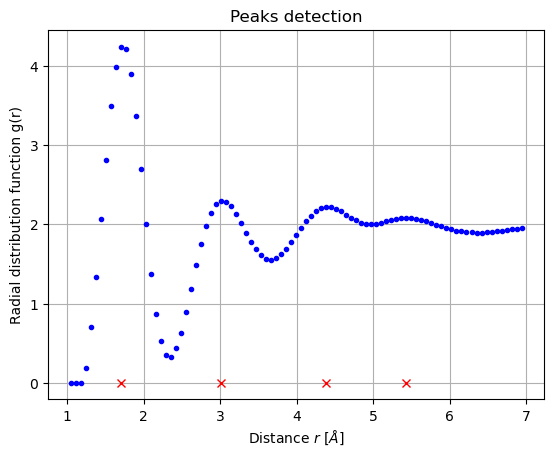

Peak 1 fit parameters
Peak position 1.731 +/- 0.001 Å
Peak height 4.29 +/- 0.02
Peak width 0.241 +/- 0.002 Å
Chi squared/dof 34.57459476010168
Peak 2 fit parameters
Peak position 3.055 +/- 0.005 Å
Peak height 2.3 +/- 0.02
Peak width 0.44 +/- 0.01 Å
Chi squared/dof 69.11150470479224
Peak 3 fit parameters
Peak position 4.433 +/- 0.004 Å
Peak height 2.218 +/- 0.004
Peak width 0.76 +/- 0.02 Å
Chi squared/dof 13.473557663724648
Peak 4 fit parameters
Peak position 5.429 +/- 0.006 Å
Peak height 2.075 +/- 0.002
Peak width 1.48 +/- 0.03 Å
Chi squared/dof 6.66076055030961


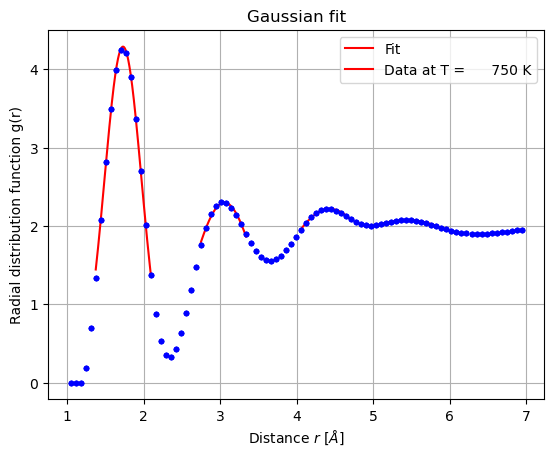

In [13]:
peak_label = ['Peak 1', 'Peak 2', 'Peak 3', 'Peak 4']
gdr_peaks_tot = []
delta_gdr_peaks_tot = []  
height_gdr_peaks_tot = []
delta_height_gdr_peaks_tot = []
width_gdr_peaks_tot = []
delta_width_gdr_peaks_tot = []

print('######## Nearest neighbours distances #########')
print('Ge-O: 1.73 Å')
print('O-O: 2.82 Å')
print('Ge-Ge: 3.16 Å')
print('################')

for i in range(len(T)):

    print('######## T = %8.0f  K ########' % T[i] )

    index = get_indices_in_range(r,1,7)
    shift = r[index]
    intensity = gdr[i][index]
    err_intensity = err_gdr[i][index]
    
    index_peaks = sci.signal.find_peaks(intensity,height=1,distance=10)[0]
    widths = sci.signal.peak_widths(intensity,index_peaks, rel_height=0.0035)[0]

    shift_peak= []
    intensity_peaks = []

    i=0
    while(i<index_peaks.size):
        shift_peak.append(shift[index_peaks[i]])
        intensity_peaks.append(intensity[index_peaks[i]])
        i=i+1

    larghezza_in_shift = widths*2
    #print(shift_peak,larghezza_in_shift)


    shift_peak = np.array(shift_peak) 

    plt.plot(shift,intensity,'.',color='blue')
    plt.plot(shift_peak,[0]*len(shift_peak),'x',color='red')
    plt.title('Peaks detection')
    plt.xlabel(r'Distance $r$ [$Å$]')
    plt.ylabel('Radial distribution function g(r)')
    plt.grid()
    plt.show()


    ranges = []
    for j in range(len(shift_peak)):
        shift_sup = shift_peak[j]+larghezza_in_shift[j]/2
        shift_inf = shift_peak[j]-larghezza_in_shift[j]/2
        coord = (shift_inf,shift_sup)
        ranges.append(coord)

    gdr_peaks = []
    delta_gdr_peaks = []  
    height_gdr_peaks = []
    delta_height_gdr_peaks = []
    width_gdr_peaks = []
    delta_width_gdr_peaks = []

    ranges = [[1.35,2.1],[2.7,3.4],[4,4.75],[5,6]]   #serve modo per automatizzare --> se fallisce il fit rifallo su più/meno punti finchè non viene [1.4,2],[2.7,3.4],[4,4.75]
    i = 0
    for start, end in ranges:

        x_indices = get_indices_in_range(shift, start, end)
        first_peak_x = shift[x_indices]
        first_peak_y = intensity[x_indices]
        sigma =err_intensity[x_indices]

        #p0 = [max(first_peak_y), np.mean(first_peak_x), 1]
        popt, pcov = curve_fit(gaussian,first_peak_x, first_peak_y,sigma=sigma,maxfev=80000)  # ,bounds=([min(first_peak_y),min(first_peak_x),0.1],[2*max(first_peak_y),max(first_peak_x),2*abs(max(first_peak_x)-min(first_peak_x))])
        chi_sq = np.sum((first_peak_y-gaussian(first_peak_x, *popt))**2/sigma**2)/(np.size(first_peak_y)-3)
        print( peak_label[i],'fit parameters')
        par = my_round(popt,np.sqrt(np.diag(pcov)))
        print('Peak position',par[1][0], '+/-', par[1][1],'Å')
        print('Peak height',par[0][0], '+/-', par[0][1])
        print('Peak width', par[2][0], '+/-', par[2][1], 'Å')
        print('Chi squared/dof', chi_sq)
        
        gdr_peaks.append(popt[1])
        height_gdr_peaks.append(popt[0])
        width_gdr_peaks.append(popt[2])

        delta_gdr_peaks.append(np.sqrt(pcov[1][1]) )
        delta_height_gdr_peaks.append(np.sqrt(pcov[0][0]))
        delta_width_gdr_peaks.append(np.sqrt(pcov[2][2]))

        i +=1
        x_plot = np.linspace(min(first_peak_x), max(first_peak_x),10000)
        plt.plot(x_plot, gaussian(x_plot, *popt),color='red')
        plt.errorbar(shift,intensity,yerr=err_intensity,fmt='.',color='blue')
    plt.title('Gaussian fit')
    plt.legend(['Fit', 'Data at T = %8.0f K' % T[i]])
    plt.grid()
    plt.xlabel(r'Distance $r$ [$Å$]')
    plt.ylabel('Radial distribution function g(r)')
    plt.show()

    gdr_peaks_tot.append(gdr_peaks)
    delta_gdr_peaks_tot.append(delta_gdr_peaks) 
    height_gdr_peaks_tot.append(height_gdr_peaks)
    delta_height_gdr_peaks_tot.append(delta_height_gdr_peaks)
    width_gdr_peaks_tot.append(width_gdr_peaks)
    delta_width_gdr_peaks_tot.append(delta_width_gdr_peaks)

gdr_peaks_tot=np.array(gdr_peaks_tot)
delta_gdr_peaks_tot=np.array(delta_gdr_peaks_tot)
height_gdr_peaks_tot=np.array(height_gdr_peaks_tot)
delta_height_gdr_peaks_tot=np.array(delta_height_gdr_peaks_tot)
width_gdr_peaks_tot=np.array(width_gdr_peaks_tot)
delta_width_gdr_peaks_tot=np.array(delta_width_gdr_peaks_tot)

### Study the peaks temperature evolution

### $G(r)$

Peak position

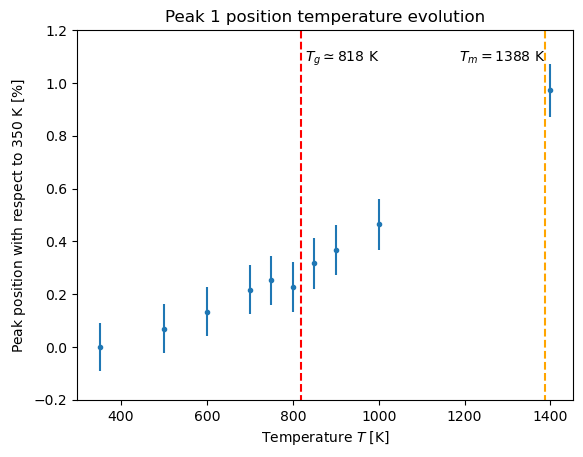

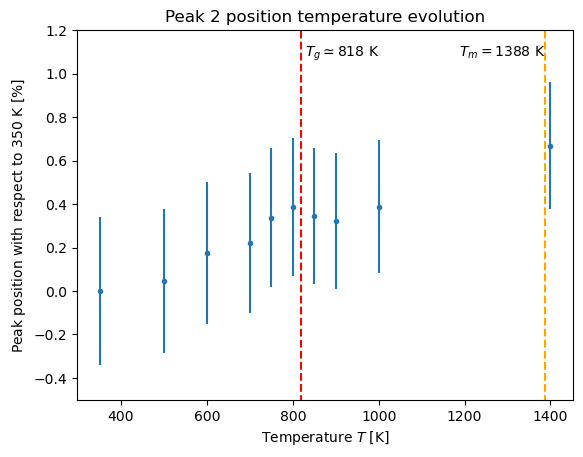

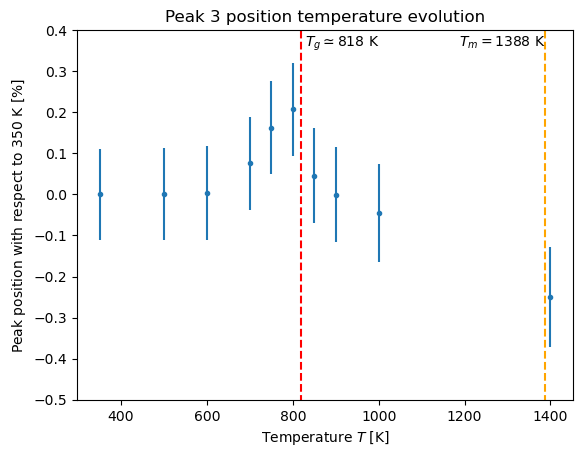

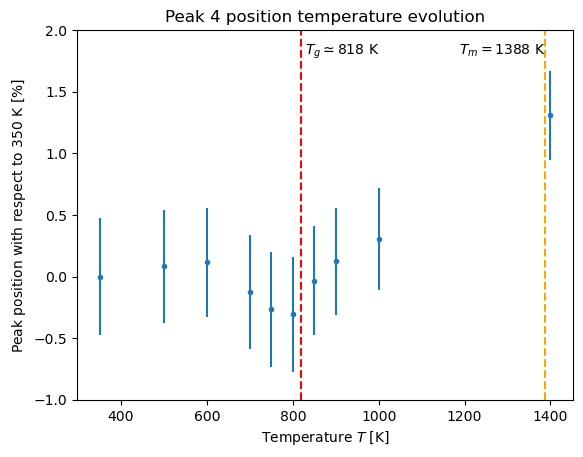

In [14]:
Tg = 818 #K
Tm = 1388 #K
ymin = [-0.2,-0.5,-0.5,-1]
ymax = [1.2, 1.2, 0.4, 2]
for i in range(len(gdr_peaks_tot.transpose())):
    peak = 100*(gdr_peaks_tot[:,i]/gdr_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_gdr_peaks_tot[:,i]/gdr_peaks_tot[0,i])**2+(gdr_peaks_tot[:,i]*delta_gdr_peaks_tot[0,i]/gdr_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak position with respect to 350 K [$\%$]')
    plt.title('Peak %d position temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-1,-1],[2,2], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

Peak width

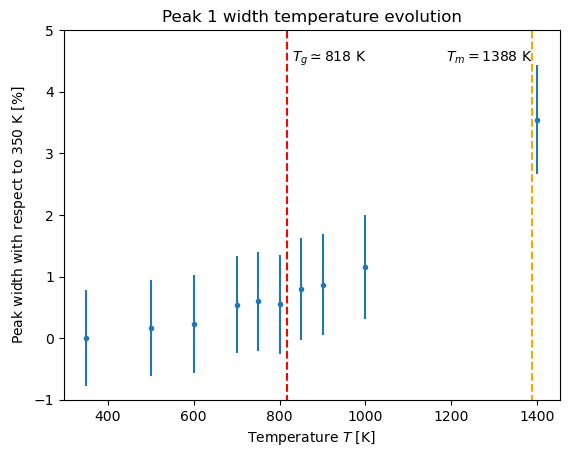

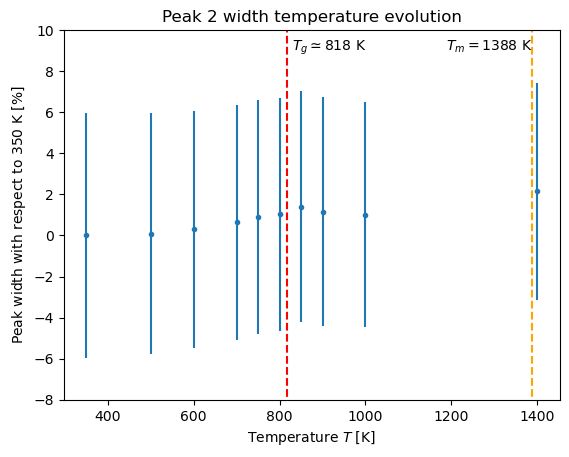

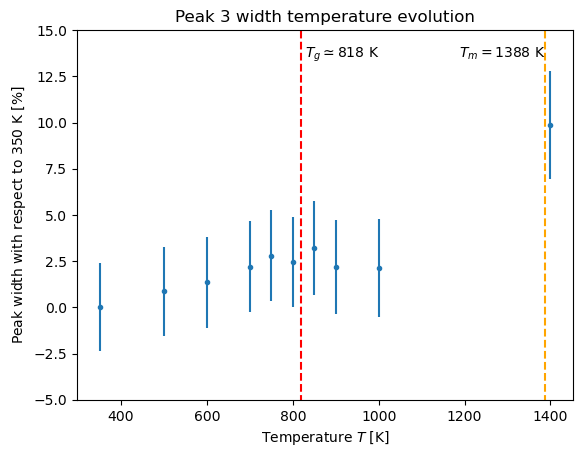

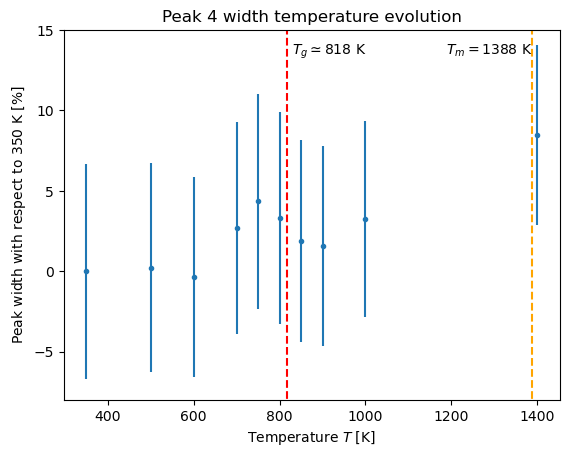

In [15]:
ymin = [-1,-8,-5,-8]
ymax = [5, 10, 15, 15]
for i in range(len(width_gdr_peaks_tot.transpose())):
    peak = 100*(width_gdr_peaks_tot[:,i]/width_gdr_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_width_gdr_peaks_tot[:,i]/width_gdr_peaks_tot[0,i])**2+(width_gdr_peaks_tot[:,i]*delta_width_gdr_peaks_tot[0,i]/width_gdr_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak width with respect to 350 K [$\%$]')
    plt.title('Peak %d width temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-10,-10],[20,20], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

Peak intensity

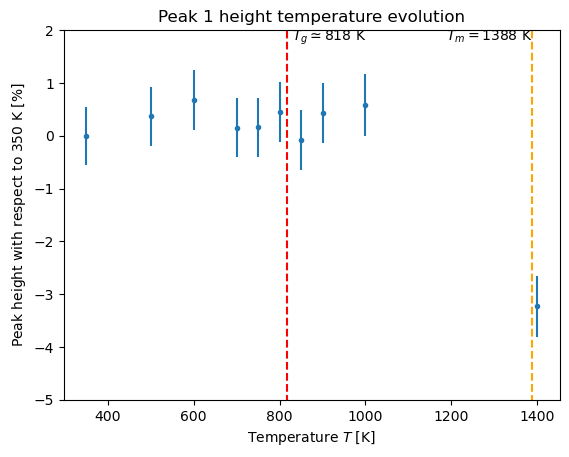

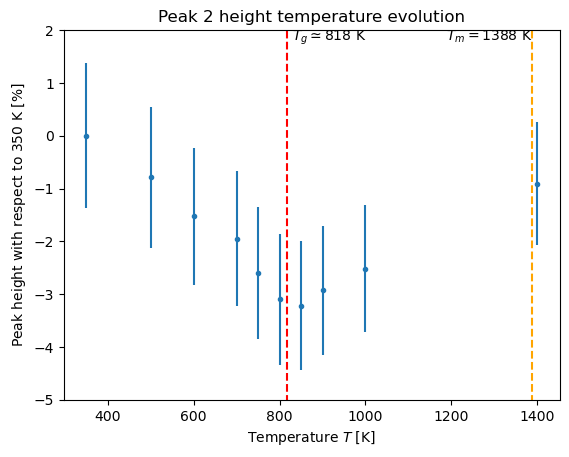

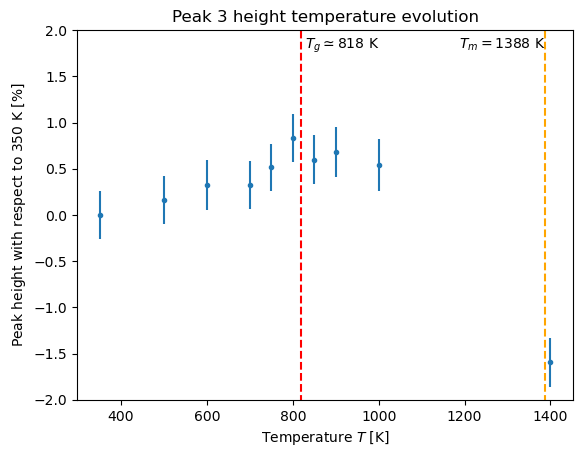

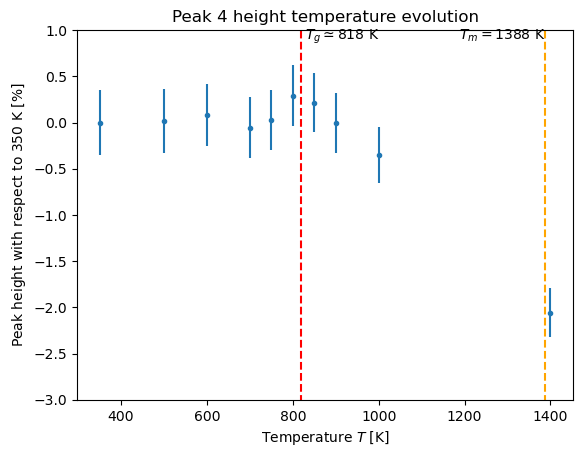

In [16]:
ymin = [-5,-5,-2,-3]
ymax = [2, 2, 2, 1]
for i in range(len(height_gdr_peaks_tot.transpose())):
    peak = 100*(height_gdr_peaks_tot[:,i]/height_gdr_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_height_gdr_peaks_tot[:,i]/height_gdr_peaks_tot[0,i])**2+(height_gdr_peaks_tot[:,i]*delta_height_gdr_peaks_tot[0,i]/height_gdr_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak height with respect to 350 K [$\%$]')
    plt.title('Peak %d height temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-10,-10],[20,20], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

Main effects are observed after $T_m$, but some structural changes are observed also at $T_g$.  
$G(r)$  
Peak position $\nearrow$ : coordination shell enlarges  
Peak width $\nearrow$: positions in the coordination shell are more spread  
Peak intensity $\nearrow$: more atoms in the shell  

### $S(Q)$

Peak position

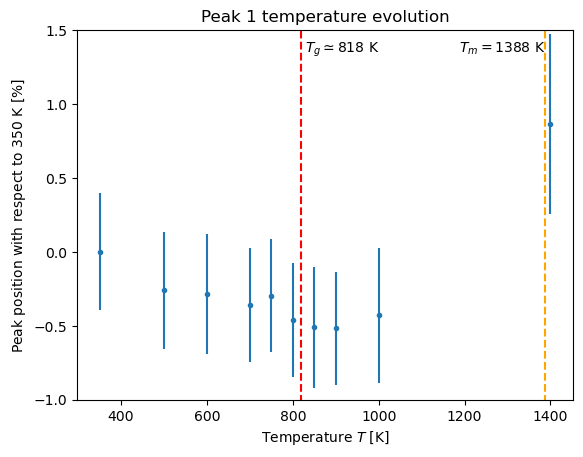

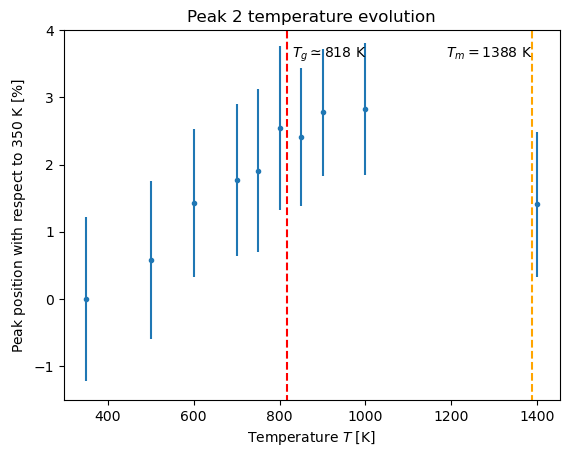

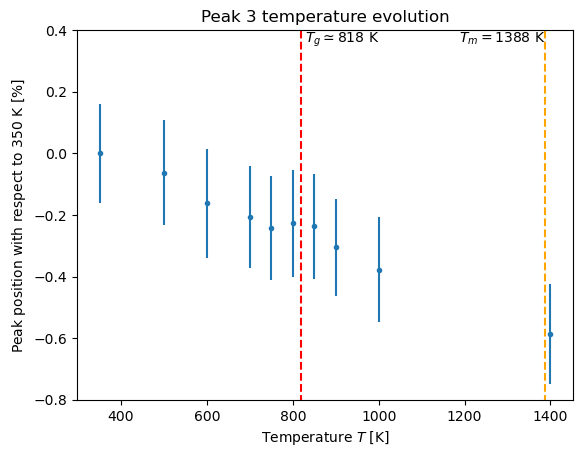

In [17]:
ymin = [-1,-1.5,-0.8]
ymax = [1.5, 4, 0.4]
for i in range(len(sdq_peaks_tot.transpose())):
    peak = 100*(sdq_peaks_tot[:,i]/sdq_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_sdq_peaks_tot[:,i]/sdq_peaks_tot[0,i])**2+(sdq_peaks_tot[:,i]*delta_sdq_peaks_tot[0,i]/sdq_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak position with respect to 350 K [$\%$]')
    plt.title('Peak %d temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-10,-10],[20,20], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

Peak width

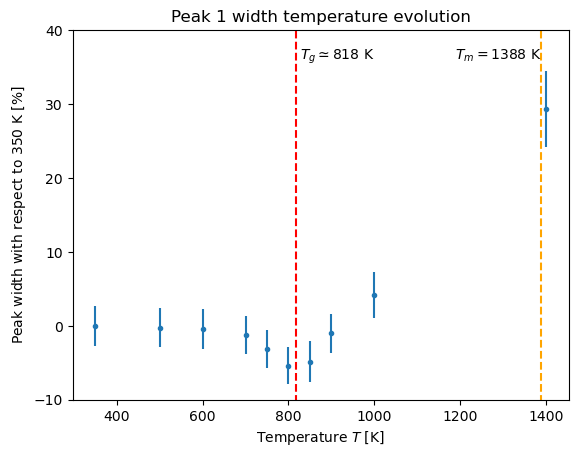

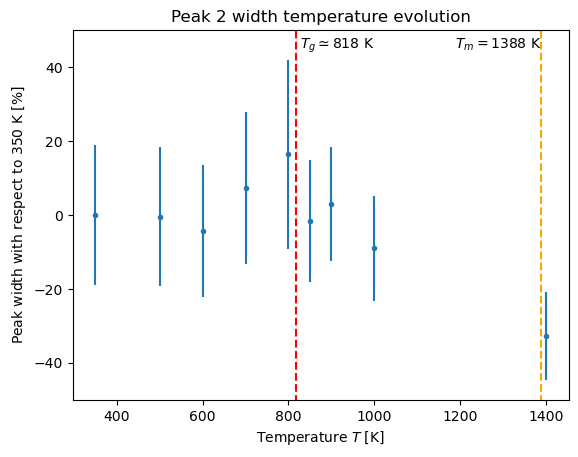

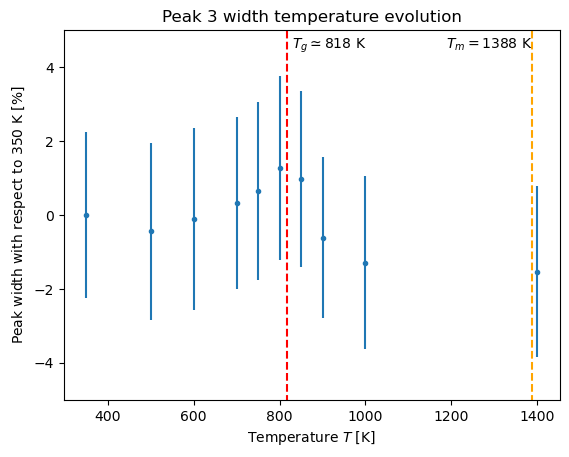

In [18]:
ymin = [-10,-50,-5]
ymax = [40, 50, 5]
for i in range(len(width_sdq_peaks_tot.transpose())):
    peak = 100*(width_sdq_peaks_tot[:,i]/width_sdq_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_width_sdq_peaks_tot[:,i]/width_sdq_peaks_tot[0,i])**2+(width_sdq_peaks_tot[:,i]*delta_width_sdq_peaks_tot[0,i]/width_sdq_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak width with respect to 350 K [$\%$]')
    plt.title('Peak %d width temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-100,-100],[200,200], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

Peak height

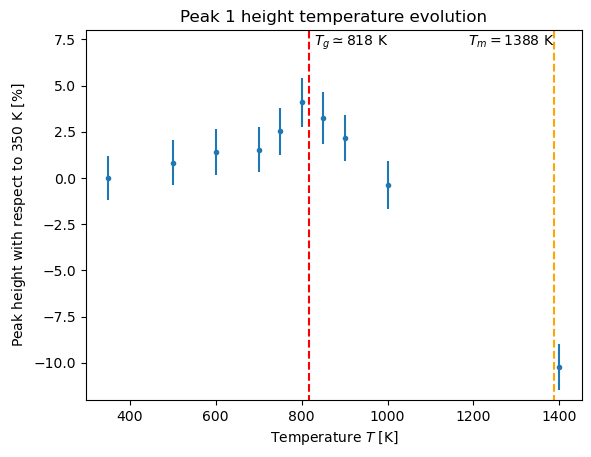

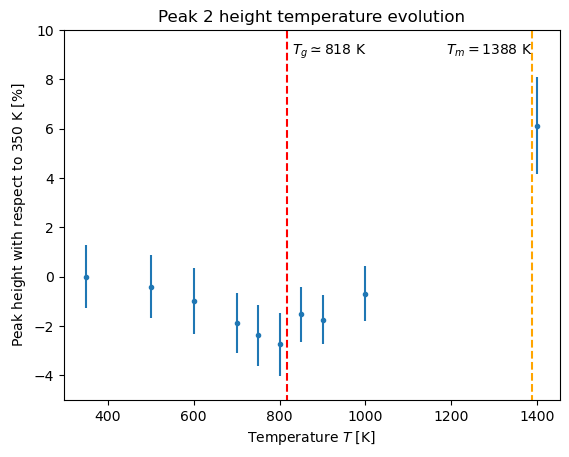

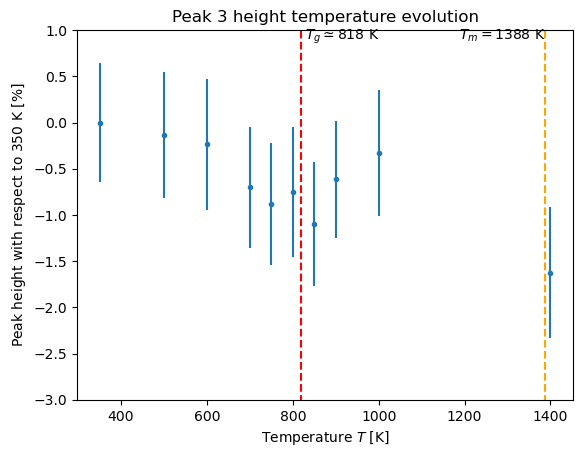

In [19]:
ymin = [-12,-5,-3]
ymax = [8, 10, 1]
for i in range(len(height_sdq_peaks_tot.transpose())):
    peak = 100*(height_sdq_peaks_tot[:,i]/height_sdq_peaks_tot[0,i]-1)
    err_peak = 100*np.sqrt((delta_height_sdq_peaks_tot[:,i]/height_sdq_peaks_tot[0,i])**2+(height_sdq_peaks_tot[:,i]*delta_height_sdq_peaks_tot[0,i]/height_sdq_peaks_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Peak height with respect to 350 K [$\%$]')
    plt.title('Peak %d height temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-100,-100],[200,200], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.9*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.9*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

# Coordination

Determine the coordination number via the $N(r)$ function

$$
N(r) = 4 \pi n_{GeO_2} \int_0^r dr' r'^2 g(r')
$$

Here integrate $g(r)$, possible errors as Simpson's integration is exact just for low order polynomials.

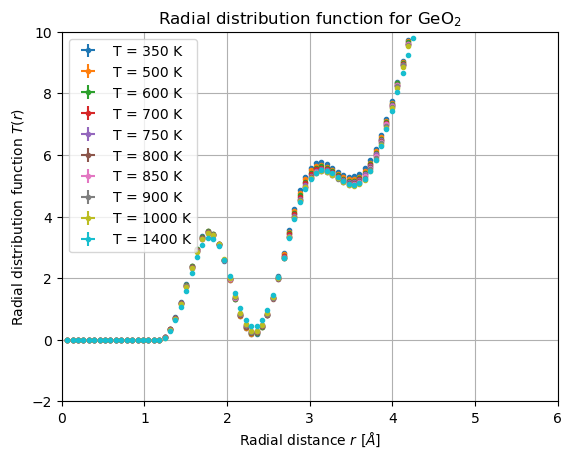

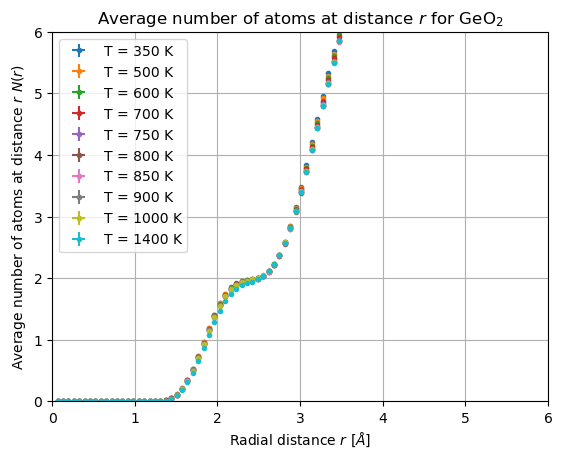

In [20]:
Tdr = [] 
err_Tdr = [] 


for i in range(len(T)):
    tdr = 4*np.pi*n_geo2[i]*r**2*gdr[i]
    err_tdr = np.divide(err_gdr[i], gdr[i], out=np.zeros_like(err_gdr[i]), where=gdr[i]!=0)  # t avoid problems where gdr = 0
    err_tdr = tdr*np.sqrt(err_tdr**2+(err_r/r)**2)

    Tdr.append(tdr)
    err_Tdr.append(err_tdr)
    plt.errorbar(r,tdr, fmt = '.', yerr = err_tdr, xerr= err_r,label = 'T = %d K' %T[i])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Radial distribution function $T(r)$')
plt.title(r'Radial distribution function for GeO$_2$')
plt.xlim(0,6)
plt.ylim(-2,10)
plt.grid()
plt.legend(loc='upper left')
plt.show()


Ndr = []
err_Ndr = []

for j in range(len(T)):
    ndr = np.zeros(len(r))
    err_ndr = [0]
    for i in range (1,len(r)):
        ndr[i] = sci.integrate.simpson(Tdr[j][0:i], r[0:i])
        err_integrand = err_Tdr[j][0:i]
        err_ndr.append(4*np.pi*n_geo2[j]*(max(r)-min(r))/(3*(len(r)-1))*np.sqrt(abs(-3*err_integrand[0]**2-15*err_integrand[-1]**2+sum(4*err_integrand[::2]**2)+sum(16*err_integrand[1::2]**2))))

    Ndr.append(ndr)
    err_Ndr.append(err_ndr)
    plt.errorbar(r,ndr, fmt = '.', yerr = err_ndr, xerr= err_r,label = 'T = %d K' %T[j])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Average number of atoms at distance $r$ $N(r)$')
plt.title(r'Average number of atoms at distance $r$ for GeO$_2$')
plt.xlim(0,6)
plt.ylim(0,6)
plt.grid()
plt.legend(loc='upper left')
plt.show()

Here compute directly $N(r)$ from $S(Q)$ as

$$
N(r) = \frac{\left(\sum\limits_{\alpha}b_{coh,\alpha}\right)^2}{\sum\limits_{\alpha}b_{coh,\alpha}^2}\frac{4}{3} \pi n_{GeO_2} r^3 + \frac{2}{\pi} \int_0^{Q_{max}} dQ\left(S(Q)-1\right) \left( \sin (Qr)-Qr\cos(Qr)\right)/Q
$$

Revised from  @article{petrillo1989hydration,  
  title={Hydration structure of ethanol water solution at low alcohol concentration},  
  author={Petrillo, Caterina and Onori, G and Sacchetti, Francesco},  
  journal={Molecular Physics},  
  volume={67},  
  number={3},  
  pages={697--705},  
  year={1989},  
  publisher={Taylor \& Francis}  
}  
My result leads to different prefactor for the integral in $Q$ and the $1/Q^3$ is most likely a typo.

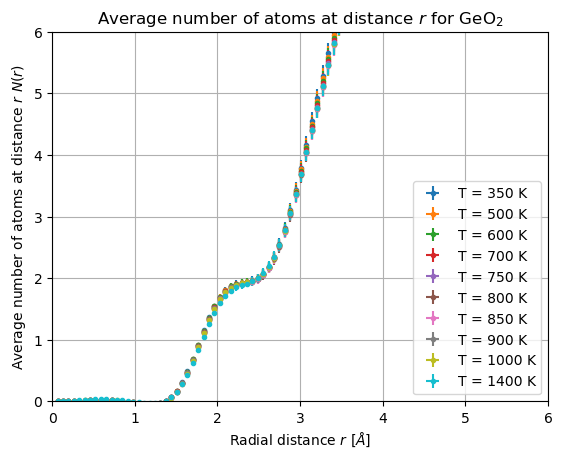

In [21]:
# Compute directly Ndr from Sdq to avoid numerical errors in double integration

ndr = []
err_ndr = []

for i in range(len(T)):
    integral = np.zeros(len(r))
    err_integral = np.zeros(len(r))
    for j in range(len(r)):
        integrand = sdq_flattened[i]*(np.sin(q*r[j])-q*r[j]*np.cos(q*r[j]))/q
        err_integrand = np.sqrt((err_sdq_flattened[i]*(np.sin(q*r[j])-q*r[j]*np.cos(q*r[j]))/q)**2+(err_q*sdq_flattened[i]*(q**2*r[j]**2*np.cos(q*r[j]*(1+q*r[j])-np.sin(q*r[j]))/q**2))**2+(err_r[j]*sdq_flattened[i]*q*r[j]*np.sin(q*r[j]))**2)
        integral[j] = sci.integrate.simpson(integrand,q)
        err_integral[j] = (max(q)-min(q))/(3*(len(q)-1))*np.sqrt(-3*err_integrand[0]**2-15*err_integrand[-1]**2+sum(4*err_integrand[::2]**2)+sum(16*err_integrand[1::2]**2))  #propagate error form Simpson integral formula

    funz = A*4*np.pi*n_geo2[i]*r**3/3 +2/np.pi*integral
    err_funz = np.sqrt((err_integral*2/np.pi)**2+(err_r*A*3*np.pi*r**2)**2)
    
    ndr.append(funz)
    err_ndr.append(err_funz)
    plt.errorbar(r,funz, fmt = '.', yerr = err_funz, xerr= err_r,label = 'T = %d K' %T[i])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Average number of atoms at distance $r$ $N(r)$')
plt.title(r'Average number of atoms at distance $r$ for GeO$_2$')
plt.xlim(0,6)
plt.ylim(0,6)
plt.grid()
plt.legend(loc='lower right')
plt.show()

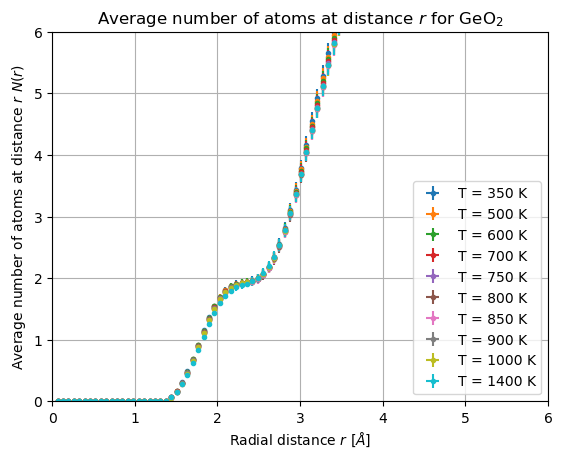

In [22]:
#remove unpysical ndr < 0 values

ndr,err_ndr = process_matrix(ndr,err_ndr)

for i in range(len(T)):
    plt.errorbar(r,ndr[i], fmt = '.', yerr = err_ndr[i], xerr= err_r,label = 'T = %d K' %T[i])

plt.xlabel(r'Radial distance $r$ [$\AA$]')
plt.ylabel('Average number of atoms at distance $r$ $N(r)$')
plt.title(r'Average number of atoms at distance $r$ for GeO$_2$')
plt.xlim(0,6)
plt.ylim(0,6)
plt.grid()
plt.legend(loc='lower right')
plt.show()

Cfr. between two ways to compute $N(r)$

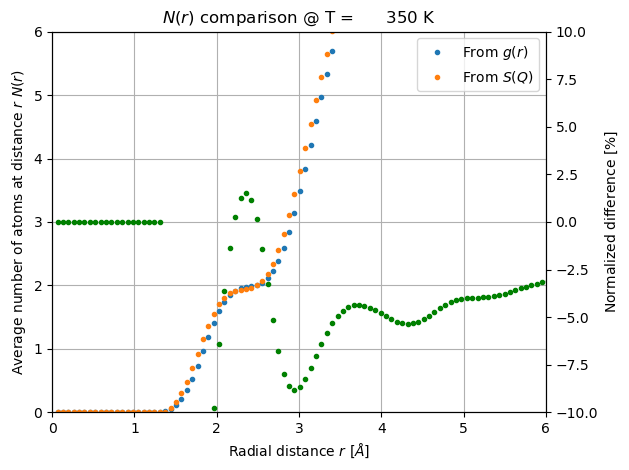

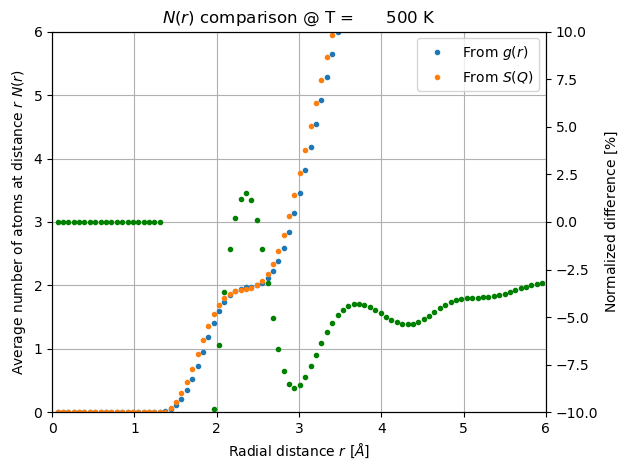

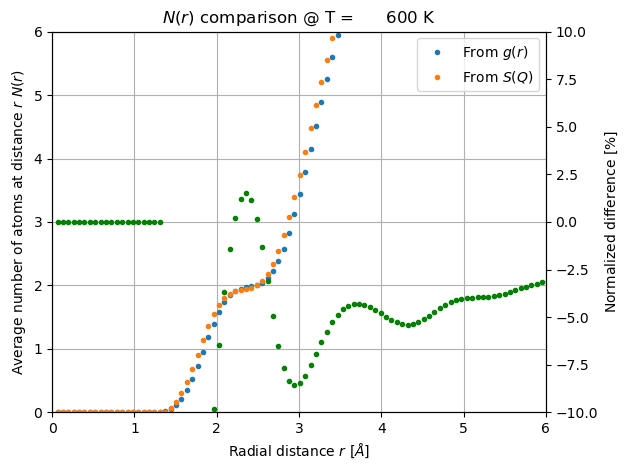

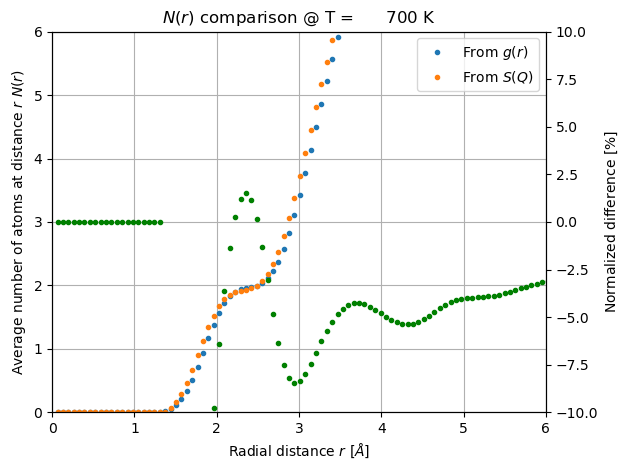

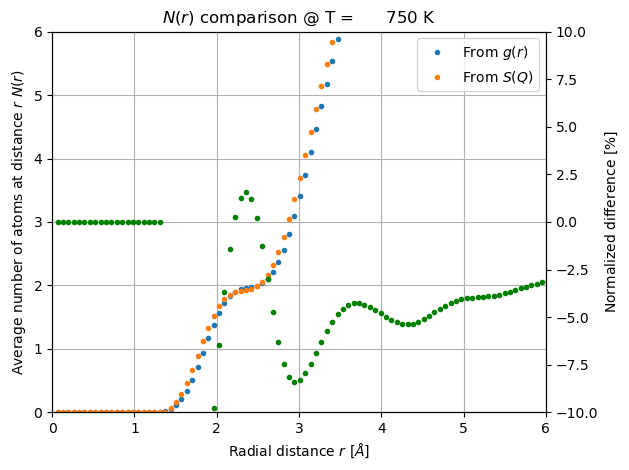

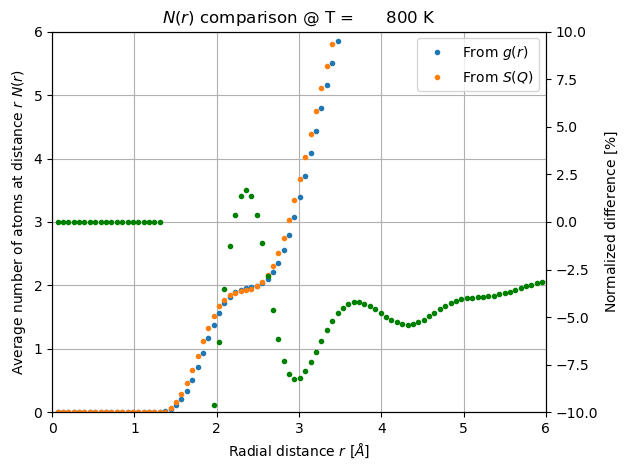

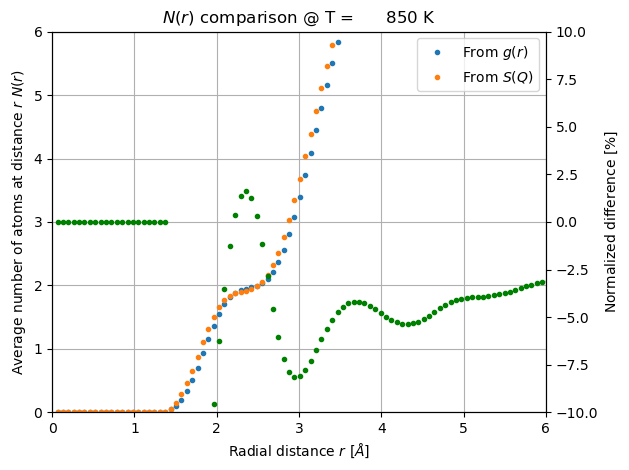

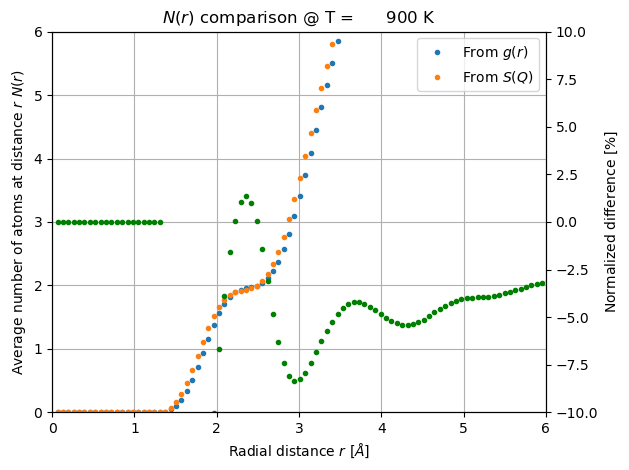

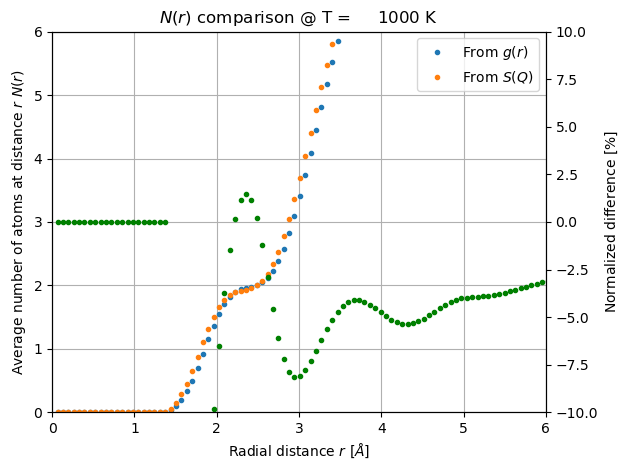

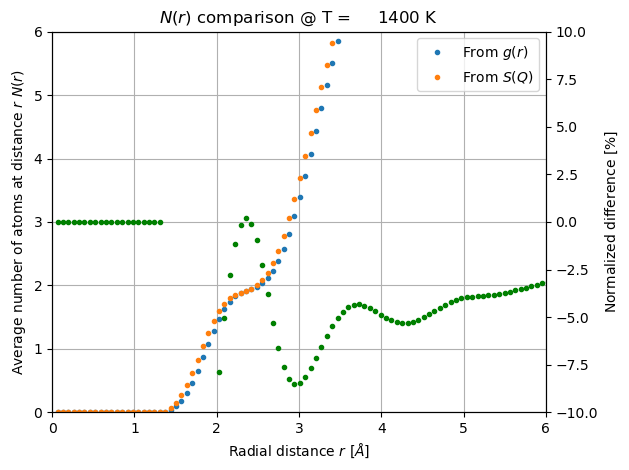

In [23]:
for i in range(len(T)):
    diff= 200*np.divide((Ndr[i]-ndr[i]),(Ndr[i]+ndr[i]),out=np.zeros_like(Ndr[i]), where=np.logical_and(Ndr[i],ndr[i]) !=0) # to avoid problems where Ndr+ndr = 0

    fig, ax1 = plt.subplots()
    ax1.plot(r,Ndr[i],'.',label = r'From $g(r)$')
    ax1.plot(r,ndr[i],'.',label=r'From $S(Q)$')
    ax1.set_xlabel(r'Radial distance $r$ [$\AA$]')
    ax1.set_ylabel('Average number of atoms at distance $r$ $N(r)$')
    ax1.set_title(r'$N(r)$ comparison @ T = %8.0f K' %T[i])
    ax1.set_xlim(0,6)
    ax1.set_ylim(0,6)
    ax1.grid()
    ax1.legend(loc='upper right')

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.set_ylabel(r'Normalized difference [$\%$]')  # we already handled the x-label with ax1
    ax2.plot(r,diff,'.',color='g')
    ax2.tick_params(axis='y')
    ax2.set_ylim(-10,10)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



### Find coordination shells and number

Visualize the coordination shells (between consecutive minima of $g(r)$) and the coordination number of each shell. This is computed as the value of $N(r)$ in the rightmost minima of the shell minus the value of all the previous shells. This result is a global coordination for the whole $G(r)$, defined as in the monoatomic case, the actual coordination of the single atomic species is not starightforwardly related and genearlly needs to be retrieved from the partial radila distribution functions.  

It is also possible to obtain local coordinations from total radial distribution functions, where individual peaks are known to arise from only one partial radial distribution function, although extra care is required to scale the result with the appropriate scattering factors (A comparison of various commonly used correlation functions for describing total scattering David A. Keen). In this case, following Sacchetti definition:

$$
G(r) = \frac{\sum\limits_{\alpha,\beta}b_{coh,\alpha}b_{coh,\beta}g_{\alpha\beta}(r)}{\sum\limits_{\alpha}b_{coh,\alpha}^2}
$$

Then, as the first peak in $G(r)$ is to be attributed to the Ge-O tetrahedra one can retrieve the germanium-oxygen coordination by multiplying the previously retrieved coordination by the factor $(b_{coh,Ge}^2+b_{coh,O}^2)/b_{coh,Ge}b_{coh,O}$. The other peaks are not ascribed to a single partial $g(r)$, then this simple identifcation is not possible. Hopefully the partial $g(r)$ retrieved with RMC algorithm will be good enough to estimate also the other coordinations. 

### T =      350 K


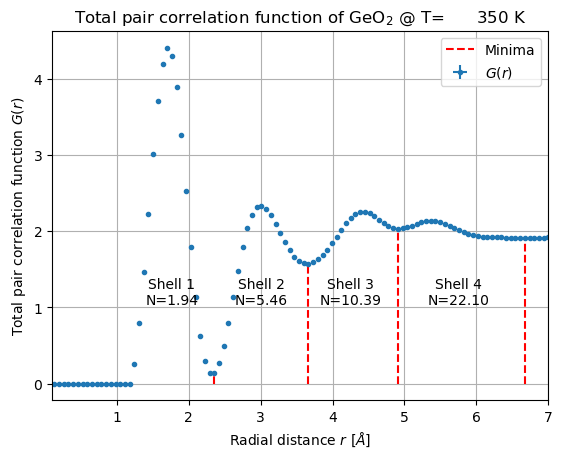

Ge-O coordination number: 4.1 +/- 0.1
### T =      500 K


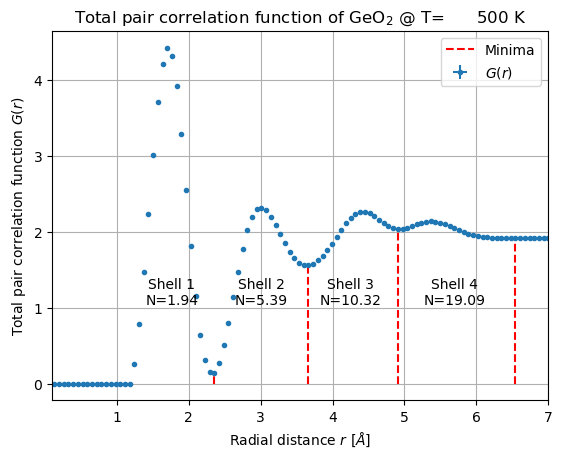

Ge-O coordination number: 4.1 +/- 0.1
### T =      600 K


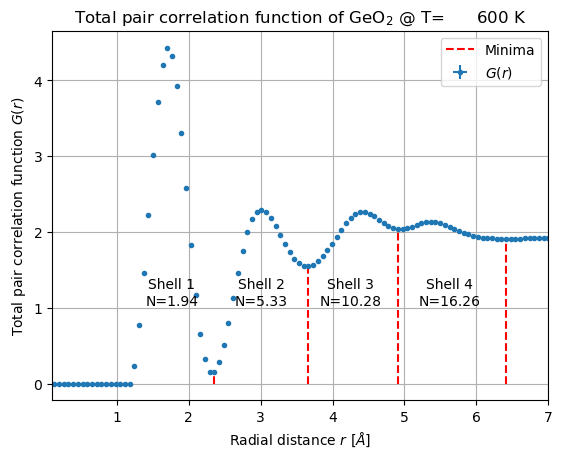

Ge-O coordination number: 4.1 +/- 0.1
### T =      700 K


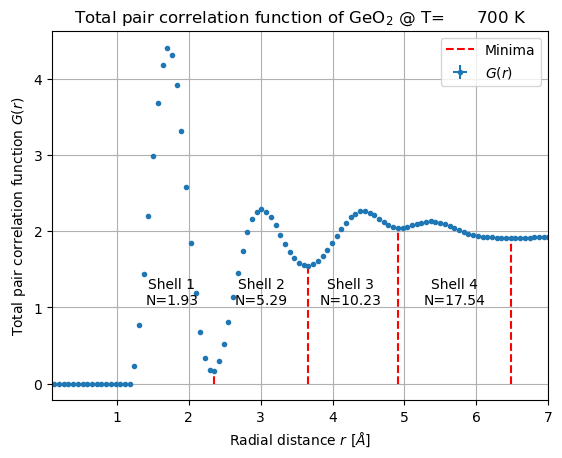

Ge-O coordination number: 4.1 +/- 0.1
### T =      750 K


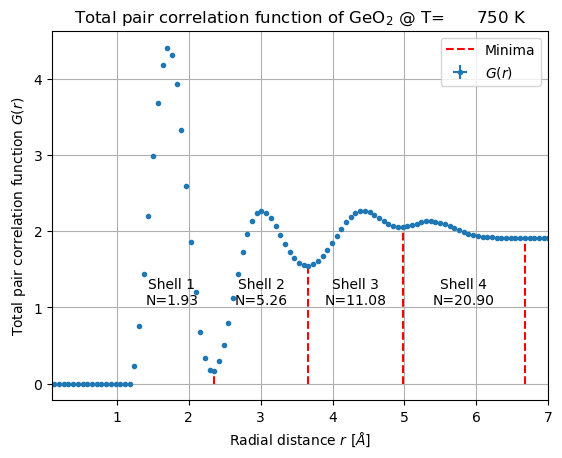

Ge-O coordination number: 4.1 +/- 0.1
### T =      800 K


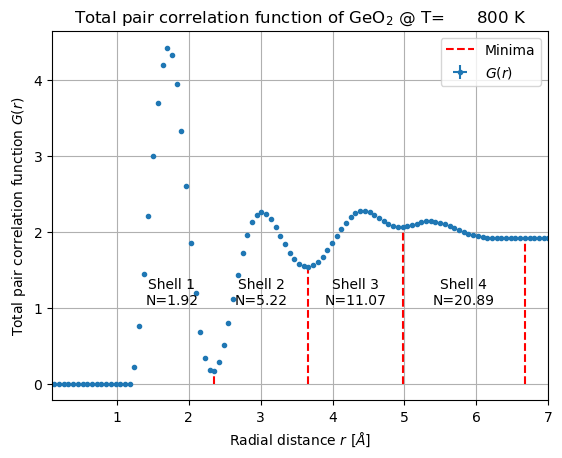

Ge-O coordination number: 4.1 +/- 0.1
### T =      850 K


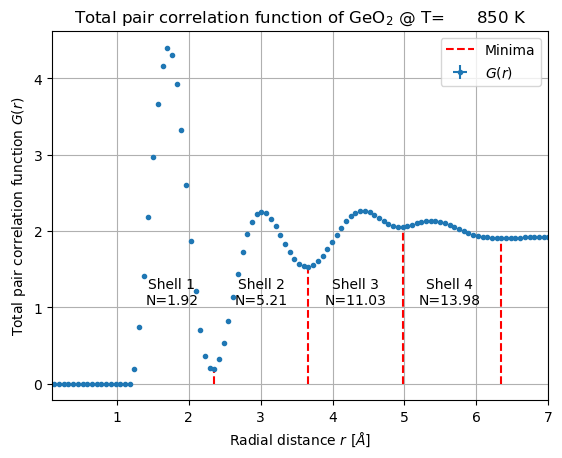

Ge-O coordination number: 4.1 +/- 0.1
### T =      900 K


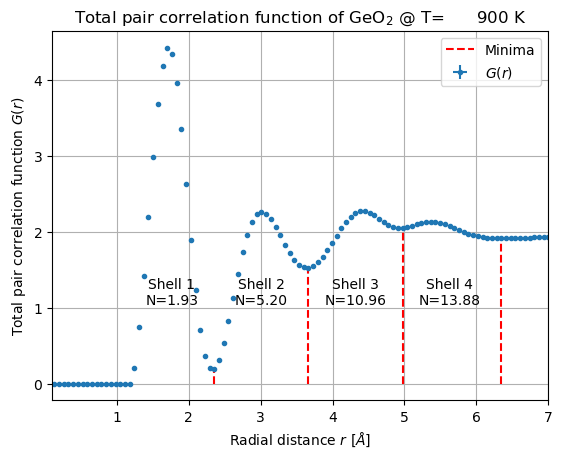

Ge-O coordination number: 4.1 +/- 0.1
### T =     1000 K


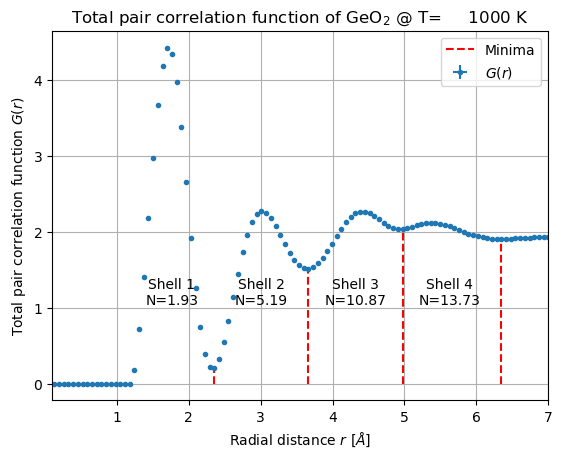

Ge-O coordination number: 4.1 +/- 0.1
### T =     1400 K


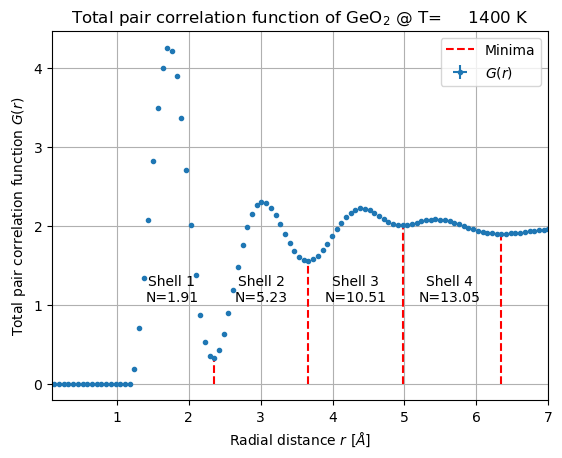

Ge-O coordination number: 4.1 +/- 0.1


In [24]:
coord_tot = []
err_coord_tot = []

for i in range(len(T)):
    print('### T = %8.0f K' %T[i])
    minima_indeces = sci.signal.argrelmin(gdr[i])[0]  #find the minima of gdr
    minima_r = r[minima_indeces]
    coord = ndr[i][minima_indeces]
    err_coord=err_ndr[i][minima_indeces]

    plt.errorbar(r,gdr[i], fmt = '.', yerr = err_gdr[i], xerr= err_r)
    plt.vlines(minima_r,0,gdr[i][minima_indeces],linestyles='dashed', colors='red')

    coord_glob = []
    err_coord_glob = []

    for j in range(4):
        if j > 0:
            start_idx = minima_indeces[j-1]
            end_idx = minima_indeces[j]
            mid_idx = (start_idx + end_idx) // 2  # Midpoint index for the coord value
        else:
            start_idx = np.where(gdr[i] == 0)[0][-1]
            end_idx = minima_indeces[j]
            mid_idx = (start_idx + end_idx) // 2  # Midpoint index for the coord value
        

        # Print coord value on the plot
        coord_num = coord[j]-sum(coord[:j])
        err_coord_num = np.sqrt(sum(err_coord[:j+1]**2))
        coord_glob.append(coord_num)
        err_coord_glob.append(err_coord_num)

        plt.text(r[mid_idx], 1, f'Shell {j+1}\nN={coord_num:.2f}', color='black', ha='center', va='bottom', fontsize=10) #({err_coord_num:.1f})
          
    plt.xlabel(r'Radial distance $r$ [$\AA$]')
    plt.ylabel('Total pair correlation function $G(r)$')
    plt.title(r'Total pair correlation function of GeO$_2$ @ T= %8.0f K' %T[i])
    plt.xlim(0.1,7)
    plt.legend(['Minima',r'$G(r)$','Coordination number'])
    plt.grid()
    plt.show()

    coord_tot.append(coord_glob)
    err_coord_tot.append(err_coord_glob)

    coord_GeO = coord[0]*(sigma_ge_coh+sigma_o_coh)/(np.sqrt(sigma_ge_coh)*np.sqrt(sigma_o_coh))
    err_coord_GeO = err_coord[0]*(sigma_ge_coh+sigma_o_coh)/(np.sqrt(sigma_ge_coh)*np.sqrt(sigma_o_coh))
    print('Ge-O coordination number:', round(coord_GeO,1),'+/-', round(err_coord_GeO,1))

coord_tot = np.array(coord_tot)
err_coord_tot = np.array(err_coord_tot)

### Global coordination evoultion with temperature

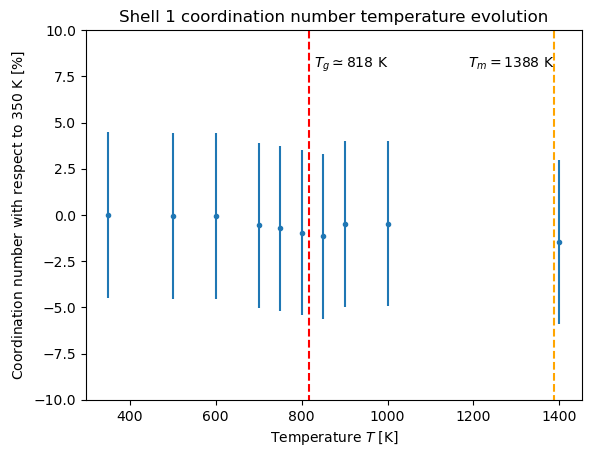

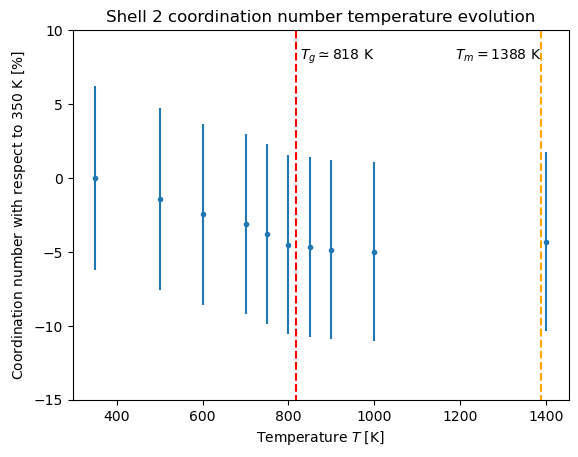

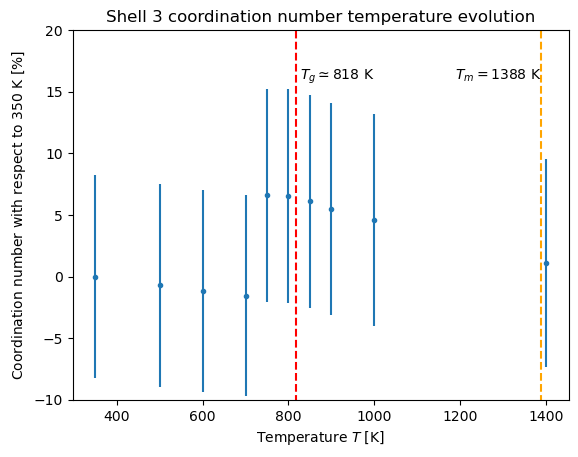

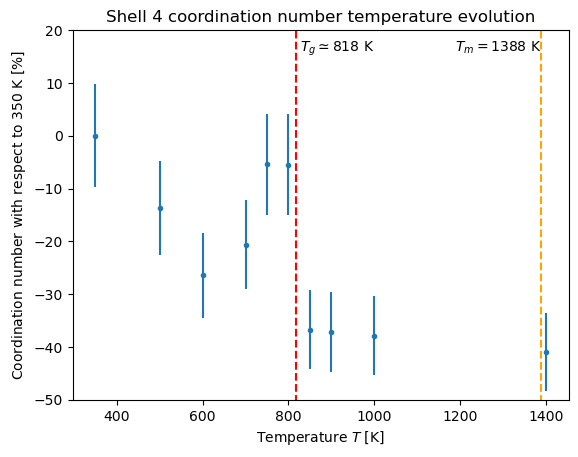

In [25]:
ymin = [-10,-15,-10,-50]
ymax = [10, 10, 20,20]
for i in range(len(coord_tot.transpose())):
    peak = 100*(coord_tot[:,i]/coord_tot[0,i]-1)
    err_peak = 100*np.sqrt((err_coord_tot[:,i]/coord_tot[0,i])**2+(coord_tot[:,i]*err_coord_tot[0,i]/coord_tot[0,i]**2)**2)

    plt.errorbar(T,peak,yerr = err_peak, fmt ='.')
    plt.xlabel(r'Temperature $T$ [K]')
    plt.ylabel(r'Coordination number with respect to 350 K [$\%$]')
    plt.title('Shell %d coordination number temperature evolution' %(i+1))

    plt.ylim(ymin[i],ymax[i])
    plt.vlines([Tg,Tm],[-100,-100],[200,200], linestyle = 'dashed', colors = ['red','orange'])
    plt.text(Tg+10,0.8*ymax[i],r'$T_g \simeq 818$ K',fontsize=10)
    plt.text(Tm-200,0.8*ymax[i],r'$T_m = 1388$ K',fontsize=10)

    plt.show()

### Export results

Export $S(Q)$ and $G(r)$ needed as input for RMC algorithm

In [26]:
for j in range(len(T)):
    file_to_open = '../../RMC/RMCProfile/Simulations/Prova/geo2_'+str(T[j])+'K_sdq.dat'

    with open(file_to_open, 'w', encoding='utf-8') as f:
        #f.write('Q S(Q) err_S(Q) \n')
        f.write(str(len(q)) +'\n geo2_'+str(T[j])+'K_sdq.dat    mutli by 1 \n')
        for i in range(len(q)):
            f.write('  ')
            f.write(str(q[i]))
            f.write('  ')
            f.write(str(sdq[j][i]))
            f.write('  ')
            f.write(str(err_sdq[j][i]))
            f.write('\n')
        f.close()

    file_to_open = '../../RMC/RMCProfile/Simulations/Prova/geo2_'+str(T[j])+'K_gdr.dat'

    with open(file_to_open, 'w', encoding='utf-8') as f:
        #f.write('r G(r) err_G(r) \n')
        f.write(str(len(r))+ '\n geo2_'+str(T[j])+'K_gdr.dat    mutli by 1 \n')
        for i in range(len(r)):
            f.write('  ')
            f.write(str(r[i]))
            f.write('  ')
            f.write(str(gdr[j][i]/A))
            f.write('  ')
            f.write(str(err_gdr[j][i]))
            f.write('\n')
        f.close()

    file_to_open = '../../RMC/RMCProfile/Simulations/Prova/geo2_'+str(T[j])+'K_peaks.dat'

    with open(file_to_open, 'w', encoding='utf-8') as f:
        #f.write('Peak position Peak height Peak width \n')
        f.write('Peak position Peak width Peak height \n')
        for i in range(len(gdr_peaks_tot[j])):
            f.write('  ')
            f.write(str(gdr_peaks_tot[j][i]))
            f.write('  ')
            f.write(str(width_gdr_peaks_tot[j][i]))
            f.write('  ')
            f.write(str(height_gdr_peaks_tot[j][i]))
            f.write('\n')
        f.close()

In [54]:

def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params)-1, 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y

def gdr_fit(x, *params):
    # Gaussian sum
    gauss = gaussian_sum(x, *params[:-1])
    
    # Asymptotic term
    idx = get_indices_in_range(x,3.5,3.55)[0]

    asympt = np.zeros_like(x[:idx])
    asympt = np.append(asympt,1 - np.exp(-(x[idx:] - x[idx])**2 / (2*params[-1]**2)))
    
    
    y = gauss + A * asympt
    
    return y

### Gaussian 0 ####
Peak position 1.7138636762698654 +/- inf channel
Peak height 4.4319674837363365 +/- inf counts
Peak width 0.23304900269090412 +/- inf channel
### Gaussian 1 ####
Peak position 3.0351716315948303 +/- inf channel
Peak height 2.319464811849887 +/- inf counts
Peak width 0.4270585633200312 +/- inf channel
### Gaussian 2 ####
Peak position 4.444100282342154 +/- inf channel
Peak height 0.7512729092684741 +/- inf counts
Peak width 0.6898693002428927 +/- inf channel
Asympote 0.6666666666666666 +/- inf Angstrom
Chi squared/dof 2551.455122210116
0.6666666666666666 inf


/tmp/ipykernel_10609/4258474409.py:5: RuntimeWarning: divide by zero encountered in divide
  chi_sq = np.sum(np.nan_to_num(((gdr[0][:]-gdr_fit(r[:], *popt))**2/err_gdr[0][:]**2)/(np.size(gdr[0][:])-len(p0)),posinf=0,neginf=0))


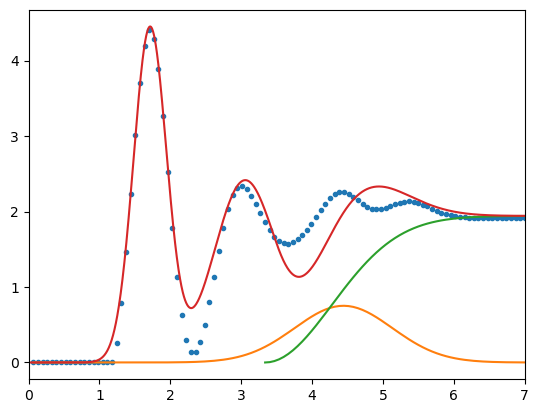

In [55]:
p0 = [height_gdr_peaks_tot[0,0],gdr_peaks_tot[0,0],width_gdr_peaks_tot[0,0],height_gdr_peaks_tot[0,1],gdr_peaks_tot[0,1],width_gdr_peaks_tot[0,1],height_gdr_peaks_tot[0,2]/3,gdr_peaks_tot[0,2],width_gdr_peaks_tot[0,2],2/3]#height_gdr_peaks_tot[0,3]/8,gdr_peaks_tot[0,3],width_gdr_peaks_tot[0,3],2/3]
bounds = [0.9*np.array(p0),1.1*np.array(p0)]
popt,pcov = curve_fit(gdr_fit,r[:],gdr[0][:],sigma =err_gdr[0][:],p0=p0)#,bounds = bounds)#gdr_fit,r:],gdr[0]:],sigma= err_gdr[0]:],p0 = p0)

chi_sq = np.sum(np.nan_to_num(((gdr[0][:]-gdr_fit(r[:], *popt))**2/err_gdr[0][:]**2)/(np.size(gdr[0][:])-len(p0)),posinf=0,neginf=0))

'''par = my_round(popt,np.sqrt(np.diag(pcov)))
for i in range(np.size(p0)//3):
    print('### Gaussian %d ####' % i)
    print('Peak position',par[3*i+1][0], '+/-', par[3*i+1][1],'channel')
    print('Peak height',par[3*i][0], '+/-', par[3*i][1],'counts')
    print('Peak width',par[3*i+2][0], '+/-', par[3*i+2][1],'channel')'''
for i in range(np.size(p0)//3):
    print('### Gaussian %d ####' % i)
    print('Peak position',popt[3*i+1], '+/-', np.sqrt(pcov[3*i+1][3*i+1]),'channel')
    print('Peak height',popt[3*i], '+/-', np.sqrt(pcov[3*i][3*i]),'counts')
    print('Peak width',popt[3*i+2], '+/-', np.sqrt(pcov[3*i+2][3*i+2]),'channel')
print('Asympote', popt[-1], '+/-',np.sqrt(pcov[-1][1]),'Angstrom')
print('Chi squared/dof', chi_sq)
print(popt[-1],np.sqrt(pcov[-1][-1]))

x_plot = np.linspace(0,max(r[:]),10000)

plt.plot(r[:],gdr[0][:],'.')
plt.plot(r,gaussian(r,*[popt[-4],popt[-3],popt[-2]]))
plt.plot(r[50:],A*(1 - np.exp(-(r[50:] - r[50])**2 /(2* popt[-1])**2)))
plt.plot(x_plot,gdr_fit(x_plot,*popt))
plt.xlim(0,7)
plt.show()



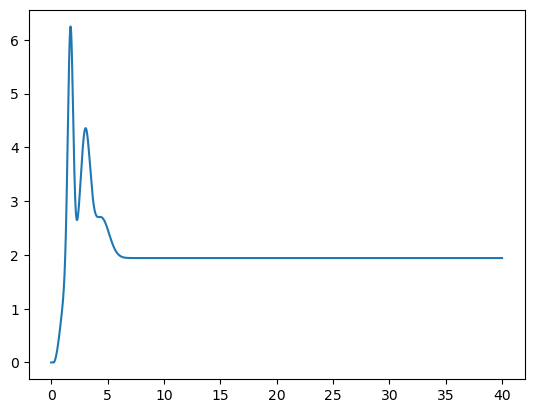

In [56]:
params = p0 
x = x_plot
gauss = gaussian_sum(x, *params[:-1])

# Asymptotic term
asympt = np.zeros_like(x[:50])
asympt = np.append(asympt,1 - np.exp(-(x[50:] - x[50])**2 / (2*params[-1]**2)))


y = gauss + A * asympt

plt.plot(x,y)
plt.show()